# covalent_api

> Endpoints for the `covalent` api: https://www.covalenthq.com/docs/api/

Summary:
    - `Address_Holder_Data` is the main API / wrapper for this notebook.

In [ ]:
#|default_exp covalent_api

In [ ]:
#| hide
from nbdev.showdoc import *

**Functionality of `Covalent_Api` class - this grabs data via the covalent API:**


`get_historical_balances`

Used to fetch the historical native, fungible (ERC20), and non-fungible (ERC721 & ERC1155) tokens held by an address at a given block height or date. Response includes daily prices and other metadata.
https://www.covalenthq.com/docs/api/balances/get-historical-token-balances-for-address/

`get_token_holders`

Get token holders as of any block height (v2).
Commonly used to get a list of all the token holders for a specified ERC20 or ERC721 token. Returns historic token holders when block-height is set (defaults to latest). Useful for building pie charts of token holders.
Note: This gets the holders by percentage (i.e. largest holdest to smallest)
https://www.covalenthq.com/docs/api/balances/get-token-holders-as-of-any-block-height-v2/


`get_holders_portfolios`

Wrapper around `get_historical_balances` to update a list of holders with their portfolios.

**Other functionality of notebook - basically ways to organise/summarise data we have accessed via Covalent_Api:**

`union_portfolios`

Computes all the coins in the top n portfolios of a token (i.e. union of all portfolios)

`intersection_count`

 For each token in the union, count how many holders have that token in their portfolio. Returns an intersection_dict.

`contract_name_if_k_holders`

Finds contracts with exactly k holders in an intersection_dict.

`contract_name_if_more_than_k_holders`

Finds contracts with more than k holders in an intersection_dict.

`holders_more_than_k_addresses`

Finds the wallets (i.e. holders) in a list of portfolios that hold more than k of a given list of addresses.

`AddressTopnToIntersectDict`

Wrapper to compute intersect_dict for the top n holders of an address.

`WalletListToIntersectDict`

Wrapper to compute intersect_dict for a given list of wallets.



In [ ]:
#| export

import json
import requests
from requests.auth import HTTPBasicAuth
from requests.exceptions import HTTPError, RequestException
import time
from fastcore.basics import *
from fastcore.test import *
from typing import List
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import api_endpoints.moralis_api as moralis_api 

In [ ]:
#| export

import logging

# Set up basic logging configuration
logging.basicConfig(level=logging.INFO, format='%(message)s')

logger = logging.getLogger(__name__)

In [ ]:
#| export

import os
from dotenv import load_dotenv

load_dotenv()

MORALIS_API_KEY = os.environ.get('moralis_api_key')
ETHERSCAN_API_KEY = os.environ.get('etherscan_api_key')
COVALENT_API_KEY = os.environ.get('covalent_api_key')

In [ ]:
#| export

#The general API is: 
#                       def some_function(self,args):
#                            url = ... #define the url using args
#                            return self.get_items(url)

#rather than writing self.get_items(url) every time, we can use a decorator to do this for us.
from requests.exceptions import HTTPError, ReadTimeout, RequestException

def url_decorator(func):
    def wrapper(self, *args, **kwargs):
        url = func(self, *args, **kwargs)
        return self.get_items(url)
        #return self.get_items_with_timeout(url)
    return wrapper

class Covalent_Api:
    """This class is used to interact with the Covalent API.
    """

    def __init__(self, covalent_api_key=COVALENT_API_KEY,etherscan_api_key=ETHERSCAN_API_KEY,request_timeout=30,retries=5,delay=1):
        self.covalent_api_key = covalent_api_key
        self.etherscan_api_key = etherscan_api_key
        self.request_timeout = request_timeout
        self.retries = retries
        self.delay = delay
        self.price_fetcher = PriceFetcher(self.etherscan_api_key, self.moralis_api_key)


    def get_items(self, url):
        """Given a url, get the items from the API."""

        headers = {"accept": "application/json"}
        basic = HTTPBasicAuth(f'{self.covalent_api_key}', '')

        while self.retries > 0:
            try:
                response = requests.get(url, headers=headers, auth=basic, timeout=self.request_timeout)
                response.raise_for_status()  
                data = response.json()['data']  # Directly access 'data' field
                
                if data is None:
                    logger.warning(f"No data received from {url}. Retries left: {self.retries}")
                    self.retries -= 1
                    time.sleep(self.delay)
                    continue

                if isinstance(data, list):
                    return data

                return data.get('items')

            except (ReadTimeout, RequestException, HTTPError) as e:
                logger.warning(f"{type(e).__name__} occurred: {e} for URL: {url}. Retrying in {self.delay} seconds...")
                self.retries -= 1
                time.sleep(self.delay)
                continue
            except Exception as e:
                logger.error(f"Unexpected error: {e} for URL: {url}. Returning None.")
                return None

        logger.warning(f"Exceeded the maximum number of retries ({self.retries}) for URL: {url} without success")
        return None

    #original. 
    # @url_decorator
    # def get_historical_balances(self,chainName:str,walletAddress:str,date:str, quote_currency="USD")->list:
    #     """
    #         API docs: https://www.covalenthq.com/docs/api/balances/get-historical-token-balances-for-address/
    #         Given a wallet address, get the historical balances for that wallet address on the specified chain and date.
    #         Inputs:
    #             `chainName`, e.g. 'eth-mainnet'
    #             `walletAddress`, e.g. '0x7364a0f792e073814B426c918bf72792575b6c18'
    #             `date`, e.g. '2021-01-01'.
    #             `quote_currency`, e.g. 'USD'
    #         Outputs:
    #             `items`, a list of dictionaries, each dictionary containing the balance of a token at a given date along with some additional metadata.
    #         Note:
    #             While the core function generates a URL, the applied @url_decorator 
    #             modifies the return behavior to fetch items using that URL.
    #     """
    #     assert type(date) is str, "date must be a string"

    #     url = f"https://api.covalenthq.com/v1/{chainName}/address/{walletAddress}/historical_balances/?quote-currency={quote_currency}&date={date}"

    #     return url 

    @url_decorator
    def _fetch_historical_balances(self, chainName: str, walletAddress: str, date: str, quote_currency="USD") -> str:
        """
        This is an internal method that just constructs and returns the URL.
        """
        assert type(date) is str, "date must be a string"
        url = f"https://api.covalenthq.com/v1/{chainName}/address/{walletAddress}/historical_balances/?quote-currency={quote_currency}&date={date}"
        return url 

    def get_historical_balances(self, chainName: str, walletAddress: str, date: str, quote_currency="USD") -> list:
        """
        Given a wallet address, get the historical balances for that wallet address on the specified chain and date.
        This method fetches the data and then processes it.
        """
        items = self._fetch_historical_balances(chainName, walletAddress, date, quote_currency)
        if items is None:
            logger.error(f"Failed to fetch data for {walletAddress} on date {date}")
            return []
        
        for i,token_data in enumerate(items):
            # if self.moralis_skip:
            #     break
    

            if token_data['balance'] in [None, "0"]:
                #print(f"Skipping: {token_data['contract_name']} has no balance or balance is 0.0")
                continue

            if token_data['quote_rate'] is None:
                if token_data['contract_decimals'] is None:
                    #print(f"Token {token_data['contract_name']} has no decimals. Skipping...")
                    continue
                # Fetch the USD price for the token on the desired_date
                assert chainName == 'eth-mainnet', "Only eth-mainnet is supported for now for `get_token_price_on_date`"
                #token_price = moralis_api.get_token_price_on_date(date, token_data['contract_address'],etherscan_api_key, moralis_api_key)                
                token_price = self.price_fetcher.get_token_price_on_date(date, token_data['contract_address'],self.etherscan_api_key, self.moralis_api_key)
                token_data['quote_rate'] = token_price
                if None in [token_data.get('balance'), token_data.get('contract_decimals'), token_price]:
                    token_data['quote'] = None
                else:
                    token_data['quote'] = (float(token_data['balance']) / (10 ** token_data['contract_decimals'])) * token_price

                #token_data['quote'] = (float(token_data['balance']) / (10 ** token_data['contract_decimals'])) * token_price

        #self.price_fetcher.save_cache() #i think this line is redunant now. 

        return items
    
    @staticmethod
    def print_balance(items):
        "Helper function to print the balance out, i.e. the object returned by `get_historical_balances`"

        for item in items:
            print(f"{item['contract_name']} balance: {item['balance']}\n")
    
    @url_decorator
    def get_token_holders(self, chainName: str, tokenAddress: str, block_height=None, page_size=100, page_number=None) -> list:
        """
        API docs: https://www.covalenthq.com/docs/api/balances/get-token-holders-as-of-any-block-height-v2/
        Fetches the token holders for a specific token on a given chain.
        Note: There is a possible `block-height` parameter, which we omit for now (see the API docs to clarify)
        
        Inputs:
            `chainName`: The chain name e.g. 'eth-mainnet'.
            `tokenAddress`: The token's address.
            `block_height`: Ending block to define a block range.
            `page_size`: Number of items per page. Supported values are 100 and 1000.
            `page_number`: 0-indexed page number to begin pagination.
        Outputs:
            `items`, a list of dictionaries, each dictionary containing information about a token holder.

        Note: This gets the holders by percentage (i.e. largest holdest to smallest)

        Note:
        While the core function generates a URL, the applied @url_decorator 
        modifies the return behavior to fetch items using that URL.
        """

        base_url = f"https://api.covalenthq.com/v1/{chainName}/tokens/{tokenAddress}/token_holders_v2/?"

        
        if block_height is not None:
            base_url += f"&block-height={block_height}"
        if page_size is not None:
            base_url += f"&page-size={page_size}"
        if page_number is not None:
            base_url += f"&page-number={page_number}"

        return base_url

    def get_holders_portfolios(self,wallet_list:List[dict],chainName:str,date:str,quote_currency="USD",log_output=False):
        """Input: 
                `wallet_list`: a list of  wallets as dicts. Each dict must contain the key 'address'.
                 See get_historical_balances for description of other inputs.
           Output: the same list of dictionaries with the portfolio added.
        """

        #TODO: this address 0x80f8c8d0d29c99b7af1b4d97cad357061037ecb3 seems to give false data (~$20m for ShibaDoge
        #Maybe should email covalent about this to let them know. Please see the dextools chart for shibadoge. 
        #We plonked the info manually into the covalent API to verify and it looks like it is an issue on their end.
        #Just something to be aware of: covalent seems to not be infallible.

        # Setting up logging level based on the log_output value
        if log_output:
            logger.setLevel(logging.INFO)
        else:
            logger.setLevel(logging.WARNING)

        #loop over the list of dictionaries (holders of the token)
        for _holder in wallet_list: #this loop should be parallelized, but ok for now provided it isn't too big.

            _address = _holder['address']
            logger.info(f'getting {_address} portfolio')  # Logging statement in place of print
            _items = self.get_historical_balances(chainName=chainName,walletAddress=_address, quote_currency=quote_currency, date=date)
            if _items == None:
                print(f'failed to get {_address} portfolio: `get_historical_balances` returned `None`')  # Logging statement in place of print
                _holder['portfolio']=None
                _holder['portfolio_sum']=None
                continue
            
            #_items is a list of dictionaries

            #get the sum of the portfolio

            #TODO: Make this more efficient: possibly convert to numpy array or dataframe or something and then sum
            
            none_to_zero = lambda x: 0 if x is None else x
            portfolio_sum = sum([none_to_zero(holding['quote']) for holding in _items])
            
            _holder['portfolio']=_items #update the _holder with the whole portfolio
            _holder['portfolio_sum']=portfolio_sum #update the _holder with the total value of the portfolio

            logger.info(f'got {_address} portfolio')  # Logging statement in place of print
            
        return wallet_list
    
    #It seems that we already have this data via `get_historical_balances` throughts ['items']['quote'] #usd value
    # @url_decorator
    # def get_prices(self,chainName:str,address:str,quote_currency="USD",dates=None):
    #     """Input: 
    #             `chainName`: e.g. 'eth-mainnet'
    #             `address`: e.g. '0x7364a0f792e073814B426c918bf72792575b6c18'
    #             `quote_currency`: e.g. 'USD'
    #             `dates`: e.g. ['2021-01-01','2021-01-10'], i.e. from,to
    #        Output: 
    #     """

    #     if len(dates)==1:
    #         dates.append(dates[0]) #if only one date is specified, then we get the price for that date only.

    #     url = f"https://api.covalenthq.com/v1/pricing/historical_by_addresses_v2/{chainName}/{quote_currency}/{address}/?from={dates[0]}&to={dates[1]}"
    #     return url
    
    @staticmethod
    def print_prices(items):
        "Helper function to print the prices out i.e. `items` as returned by `get_prices`"
        print(f"Printing out prices of: {items[0]['contract_name']}")
        for k in items[0]['prices']:
            print(f"On {k['date']}, the price was {k['price']}, and the `pretty_price` was {k['pretty_price']}")
            


How to use:

In [ ]:
###Setup: hyperparameters
cov_api = Covalent_Api() #might need to pass an API key (different to default -- see __init__ of class)
tokenAddress = '0x72e4f9F808C49A2a61dE9C5896298920Dc4EEEa9' #an erc20 token address (hpbitcoin)
chainName='eth-mainnet'
###

**How to use `get_token_holders`**: it is used to get the top token holders of a token.

In [ ]:
#get the top 100 holders of the given address
token_holders_hpbitcoin = cov_api.get_token_holders(chainName=chainName,tokenAddress=tokenAddress,page_size=100,page_number=0)
assert len(token_holders_hpbitcoin)==100
top_10_holders_hpbitcoin = token_holders_hpbitcoin[:10]
assert len(top_10_holders_hpbitcoin)==10

In [ ]:
#TODO: more tests here of `get_token_holders` here

**How to use `get_historical_balances`**:

#NOTE: Basically a helper function to compute `get_holders_portfolios`

In [ ]:
#New args required:
walletAddress = top_10_holders_hpbitcoin[3] #a wallet address
date = '2023-08-30' #a date

#Get the historical balances for a given wallet address on a given chain and date
portfolio = cov_api.get_historical_balances(chainName=chainName,walletAddress=walletAddress,date=date)

RequestException occurred: 400 Client Error: Bad Request for url: https://api.covalenthq.com/v1/eth-mainnet/address/%7B'contract_decimals':%208,%20'contract_name':%20'HarryPotterObamaSonic10Inu',%20'contract_ticker_symbol':%20'BITCOIN',%20'contract_address':%20'0x72e4f9f808c49a2a61de9c5896298920dc4eeea9',%20'supports_erc':%20%5B'erc20'%5D,%20'logo_url':%20'https://logos.covalenthq.com/tokens/1/0x72e4f9f808c49a2a61de9c5896298920dc4eeea9.png',%20'address':%20'0x2cc846fff0b08fb3bffad71f53a60b4b6e6d6482',%20'balance':%20'2057665915946569',%20'total_supply':%20'100000000000000000',%20'block_height':%2018316622%7D/historical_balances/?quote-currency=USD&date=2023-08-30 for URL: https://api.covalenthq.com/v1/eth-mainnet/address/{'contract_decimals': 8, 'contract_name': 'HarryPotterObamaSonic10Inu', 'contract_ticker_symbol': 'BITCOIN', 'contract_address': '0x72e4f9f808c49a2a61de9c5896298920dc4eeea9', 'supports_erc': ['erc20'], 'logo_url': 'https://logos.covalenthq.com/tokens/1/0x72e4f9f808c49a

In [ ]:
#TODO: tests of `get_historical_balances` here

**How to use `get_holders_portfolios`**: requires a list of holders, e.g. output from `get_token_holders`. Basically it will update the token holders with their portfolios on the provided date (so a wrapper for `get_historical_balances`):

In [ ]:
#now update token holders info by getting their whole portfolios on the given `date`. We take the list output from `get_token_holders` and update it with the portfolio info.
date = '2023-08-30'
top_10_holders_hpbitcoin = cov_api.get_holders_portfolios(wallet_list=top_10_holders_hpbitcoin,chainName=chainName,date=date)

#Can now also get information like: what was the total portfolio value of the 4th largest holder of hpbitcoin on the given date?
print(f"Total portfolio value of the 4th largest holder of hpbitcoin on {date} was: ${top_10_holders_hpbitcoin[3]['portfolio_sum']} USD")
#top_10_holders_hpbitcoin[3]['portfolio'] gives the whole portfolio of the 4th largest holder of hpbitcoin on the given date.


Got items
About to compute with moralis for token: Superconductor Crypto Coin which has balance: 20182854728994516541717011493

About to compute with moralis for token: Bald which has balance: 2923239356258343845260184

About to compute with moralis for token: LordOfTheRings10Inu which has balance: 2540915579635175

About to compute with moralis for token: KeTaiBi which has balance: 127562503975142934

About to compute with moralis for token: Hamster Bot which has balance: 28254872284383868362966006246445

About to compute with moralis for token: Pond0x V2 which has balance: 158249888633429426378299547473

About to compute with moralis for token: PUMP IT MACHINE MACHINE GAMBLE 1000X which has balance: 8739760331380997042514474

About to compute with moralis for token: BIG FLOPPA which has balance: 5156132051521260638467542440406

About to compute with moralis for token: Barbie which has balance: 8949597677231590598297387111

About to compute with moralis for token: COPENHEIMER which ha

In [ ]:
#| export

def Union_Portfolios(wallet_list:list[dict])->list:
    """Computes all the coins in `wallet_list` (i.e. union of all portfolios)    
    """
    union_portfolios = list(set(
        (item['contract_name'],item['contract_address'])
        for _portfolio in wallet_list #Basically: for each address in top_10_nickcage get all the tokens in their portfolio
        for item in _portfolio['portfolio']
                    ))
    return union_portfolios

**How to use `union_portfolios`**:

In [ ]:
union_top_10_holders_hpbitcoin = Union_Portfolios(top_10_holders_hpbitcoin)#i.e. all the tokens ("union") help by the top 10 hpbitcoin holders

In [ ]:
#| export

def intersection_count(wallet_list:list, union_lst:list) -> dict:
    """
    For each token in the union, count how many holders have that token in their portfolio.
    Inputs:
        wallet_list: list of dictionaries, each dictionary is a holder
        union_lst: list of tokens, each token is a string
    Output:
        intersect_dict: dictionary, keys are tokens, values are integers
    """

    # Create a dictionary with default value as 0
    intersect_dict = {(token_name, token_address): 0 for token_name, token_address in union_lst}

    # Pre-compute contract addresses for each holder
    holder_portfolios = {}
    for holder in wallet_list:
        holder_portfolios[holder['address']] = set(item['contract_address'] for item in holder['portfolio'])

    # Update the intersection count
    for token_name, token_address in union_lst:
        for holder_address, contracts in holder_portfolios.items():
            if token_address in contracts:
                intersect_dict[(token_name, token_address)] += 1

    return intersect_dict



**How to use `intersection_count`**:


In [ ]:
intersect_dict_top_10_hpbitcoin = intersection_count(top_10_holders_hpbitcoin,union_top_10_holders_hpbitcoin)

And we can verify the following **tests**:
- that all holders amongst the top 10 of `hpbitcoin` hold `hpbitcoin` respectively (this must be vacuously true).
- that the counts are all larger than 1 (at least one address must own the token for it to have appeared in the union)

In [ ]:
#names of the tokens
hpbitcoin_name = top_10_holders_hpbitcoin[0]['contract_name']
#addresses
hpbitcoin_address = top_10_holders_hpbitcoin[0]['contract_address']

#check that `nickcage` and `hpbitcoin` occur exactly 10 times in the top 10
test_eq(intersect_dict_top_10_hpbitcoin[(hpbitcoin_name,hpbitcoin_address)],10)

#Check that each token appears at least once 
for k in intersect_dict_top_10_hpbitcoin: assert intersect_dict_top_10_hpbitcoin[k]>=1

In [ ]:
#| export

def contract_name_if_k_holders(intersect_dict,k):
    "Get the contracts that have exactly k holders"
    if k>len(intersect_dict):
        raise ValueError("k is greater than length of intersect_dict")
    return [contract_name for contract_name in intersect_dict.keys() if intersect_dict[contract_name] == k]

def contract_name_if_more_than_k_holders(intersect_dict,k):
    "Get the contracts that have more than k holders"
    if k>len(intersect_dict):
        raise ValueError("k is greater than length of intersect_dict")
    return [contract_name for contract_name in intersect_dict.keys() if intersect_dict[contract_name] > k]

**How to use `contract_name_if_k_holders` and `contract_name_if_more_than_k_holders`**:

In [ ]:
hpbitcoin_name_if_k_holders = contract_name_if_k_holders(intersect_dict_top_10_hpbitcoin,k=10)
hpbitcoin_name_if_more_than_k_holders = contract_name_if_more_than_k_holders(intersect_dict_top_10_hpbitcoin,k=8)

print(f"hpbitcoin_name_if_k_holders: {hpbitcoin_name_if_k_holders}")
print(f"hpbitcoin_name_if_more_than_k_holders: {hpbitcoin_name_if_more_than_k_holders}")

hpbitcoin_name_if_k_holders: [('Ether', '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'), ('HarryPotterObamaSonic10Inu', '0x72e4f9f808c49a2a61de9c5896298920dc4eeea9')]
hpbitcoin_name_if_more_than_k_holders: [('ETHEREUM2.0', '0xea498670e8de236c17d75c0bd09dd4b1b6f39eb2'), ('Ether', '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'), ('HarryPotterObamaSonic10Inu', '0x72e4f9f808c49a2a61de9c5896298920dc4eeea9')]


In [ ]:
#| export

def holders_more_than_k_addresses(portfolios: list[dict], contract_addresses: list[str], k: int) -> list[dict]:
    """
    Given a list of portfolios, get the holders that hold more than k of the given addresses.
    Inputs:
        portfolios: list of portfolio (dicts)
        contract_addresses: list of contract addresses
        k: minimum number of contract_addresses a holder should have
    Output:
        list[dict]: list of holders that hold more than k of the given addresses.
    """
    lst = []
    for _holder in portfolios:
        holder_addresses = set(_token['contract_address'] for _token in _holder['portfolio'])
        if len(holder_addresses.intersection(contract_addresses)) > k:
            lst.append(_holder)
    return lst

**How to use `holders_more_than_k_addresses`**:

In [ ]:
xdoge_address = "0xd2b274cfbf9534f56b59ad0fb7e645e0354f4941" #can observe that this is in hpbitcoin_name_if_more_than_k_holders with k=8 (see above)

#the holders of hpbitcoin who also hold xdoge
hpbitcoin_xdoge_holders = holders_more_than_k_addresses(top_10_holders_hpbitcoin,[xdoge_address],k=0)
print(f"The holders of hpbitcoin who also hold xdoge are: {hpbitcoin_xdoge_holders}")
print(f"There are {len(hpbitcoin_xdoge_holders)} such holders")


The holders of hpbitcoin who also hold xdoge are: [{'contract_decimals': 8, 'contract_name': 'HarryPotterObamaSonic10Inu', 'contract_ticker_symbol': 'BITCOIN', 'contract_address': '0x72e4f9f808c49a2a61de9c5896298920dc4eeea9', 'supports_erc': ['erc20'], 'logo_url': 'https://logos.covalenthq.com/tokens/1/0x72e4f9f808c49a2a61de9c5896298920dc4eeea9.png', 'address': '0x51205a732f40e57d58c7823430e8168c4a0e685b', 'balance': '2600000100000000', 'total_supply': '100000000000000000', 'block_height': 18316622, 'portfolio': [{'contract_decimals': 8, 'contract_name': 'HarryPotterObamaSonic10Inu', 'contract_ticker_symbol': 'BITCOIN', 'contract_address': '0x72e4f9f808c49a2a61de9c5896298920dc4eeea9', 'supports_erc': ['erc20'], 'logo_url': 'https://logos.covalenthq.com/tokens/1/0x72e4f9f808c49a2a61de9c5896298920dc4eeea9.png', 'block_height': 18023703, 'last_transferred_block_height': 17773276, 'last_transferred_at': '2023-07-25T23:07:23Z', 'native_token': False, 'type': 'cryptocurrency', 'is_spam': Fal

In [ ]:
#| export

def strip_none(portfolios:List[dict])->List[dict]:
    """Strip the holdings that have no quote
        Inputs: 
            portfolios: list of `portfolio` dictionaries
        Outputs:
            portfolios: list of `portfolio` dictionaries with no `None` quotes
    """

    for portfolio in portfolios:

        stripped_portfolio=[]
        for _holding in portfolio['portfolio']:
            if _holding['quote'] != None:
                stripped_portfolio.append(_holding)
        portfolio['portfolio'] = stripped_portfolio

    return portfolios


def strip_dust(portfolios:List[dict])->List[dict]:
    """Strip the holdings that are small
        Inputs: 
            portfolios: list of `portfolio` dictionaries
        Outputs:
            portfolios: list of `portfolio` dictionaries with no `None` quotes
    """
    for portfolio in portfolios:

        stripped_portfolio=[]
        for _holding in portfolio['portfolio']:
            if float(_holding['quote']) >= 1.0: #somewhat arbitrary, we choose $1USD. can also do _holding['type'] ~= 'dust'. something to keep in mind
                stripped_portfolio.append(_holding)
        portfolio['portfolio'] = stripped_portfolio

    return portfolios

In [ ]:
top_10_holders_hpbitcoin = strip_none(top_10_holders_hpbitcoin)

In [ ]:
top_10_holders_hpbitcoin[0]['portfolio'][0].keys()

dict_keys(['contract_decimals', 'contract_name', 'contract_ticker_symbol', 'contract_address', 'supports_erc', 'logo_url', 'block_height', 'last_transferred_block_height', 'last_transferred_at', 'native_token', 'type', 'is_spam', 'balance', 'quote_rate', 'quote', 'pretty_quote', 'nft_data'])

In [ ]:
##Setup
walletAddress = '0x7364a0f792e073814B426c918bf72792575b6c18' #a wallet address
date = '2023-10-04' #a date
wallet_list = [{'address':walletAddress}]
cov_api = Covalent_Api()

#Get the historical balances for a given wallet address on a given chain and date
portfolios = cov_api.get_holders_portfolios(chainName=chainName,wallet_list=wallet_list,date=date)
portfolios = strip_none(portfolios)
portfolios = strip_dust(portfolios)

Got items
About to compute with moralis for token: Popeye which has balance: 4096686953242119607438589

About to compute with moralis for token: PopXi which has balance: 78110376997267

About to compute with moralis for token: FUCKRACE which has balance: 136925287848422085

About to compute with moralis for token: GOD which has balance: 435803648939831157

About to compute with moralis for token: Starzy which has balance: 26473283757392366222154886

About to compute with moralis for token: RICE COIN which has balance: 5071130987369915914

About to compute with moralis for token: Tang Dynasty which has balance: 77710892656847

About to compute with moralis for token: MegaMind  which has balance: 7480986519385538

About to compute with moralis for token: Happy Tree Friends which has balance: 2346998870415587134002

About to compute with moralis for token: DOGEGPT which has balance: 2150345175940046712267665651668

About to compute with moralis for token: Baconator which has balance: 4271

In [ ]:
#| export

class WalletListToIntersectDict:
    #TODO: needs a better name perhaps?
    """Wrapper to compute the `intersect_dict` given a list of wallets. Basically a map to the `intersect_dict` (and intermediate data) 
        for a given list of wallets.) Note that intermediate data (e.g. `portfolios`) is also stored and often useful.)      
        Inputs:
            cov_api: Covalent_Api instance
            wallet_list: list of wallets, of the form [{'address':wallet_1},{'address':wallet_2}]
            chainName: e.g. 'eth-mainnet'
            date: e.g. '2023-09-24'
            quote_currency: e.g. USD
    """

    def __init__(self, cov_api, wallet_list, chainName,date,quote_currency="USD"): 
        store_attr()
        self.intersect_dict = self.get_data()
        
    def get_data(self):
        self.portfolios = self.cov_api.get_holders_portfolios(wallet_list=self.wallet_list,chainName=self.chainName,date=self.date)
        self.portfolios = strip_none(self.portfolios)
        self.portfolios = strip_dust(self.portfolios)
        self.union_portfolios  = Union_Portfolios(self.portfolios)#i.e. all the tokens ("union")
        self.intersect_dict = intersection_count(self.portfolios,self.union_portfolios)

        return self.intersect_dict

How to use `WalletListToIntersectDict`

#NOTE: This is ridiculously slow after adding `moralis` functionality. Let's track down what's going on:



In [ ]:
###Setup
#chainName='eth-mainnet'
#cov_api = Covalent_Api() #might need to pass an API key (different to default -- see __init__ of class)
###
#Inputs:
wallet_1 = '0xaf2358e98683265cbd3a48509123d390ddf54534' #this guy is an early pepe whale
wallet_2 = '0x711281c1b26aaed86e40e4caaf76c1962b45e161' #this guy is an early pepe whale
wallet_list = [{'address':wallet_1},{'address':wallet_2}]
#wallet_1 >> wallet_2, but yeah.
date = '2023-09-24' #todays date.

#Out:
walletlist_to_intersect_dict = WalletListToIntersectDict(cov_api,wallet_list,chainName,date) 
intersect_dict = walletlist_to_intersect_dict.intersect_dict

Got items
About to compute with moralis for token: Ordinals which has balance: 1249349418083113018927232

About to compute with moralis for token: OG which has balance: 11644663238013680417610936330

About to compute with moralis for token: BAO which has balance: 121443021801511177649168446

About to compute with moralis for token: OG which has balance: 39600026749747599920332970607

About to compute with moralis for token: Gucci which has balance: 1193809092201013989555990240

About to compute with moralis for token: Mini Doge which has balance: 33288876935183903200

About to compute with moralis for token:  Boobs AI which has balance: 30762735596322150

About to compute with moralis for token: AMERICAN DREAM which has balance: 1302593857317962

ApiException occurred while fetching price for token 0x003281ce32a53dbbaa43dfe0c890e268117522c7 on date 2023-09-24. It's possible the API did not find the token or encountered other issues.
About to compute with moralis for token: Supabase whi

KeyboardInterrupt: 

In [ ]:
#Test:
for _portfolio in walletlist_to_intersect_dict.portfolios:
    for _holding in _portfolio['portfolio']:
        test_ne(_holding['quote'],None) #check there are no `None` values of holdings.
        assert float(_holding['quote'])>=0.01, f"Expected {_holding['quote']} to be greater than 0.01"

In [ ]:
#| export

class AddressTopnToIntersectDict(WalletListToIntersectDict):
    """Wrapper to compute the `intersect_dict` for a given tokenAddress, chainName, date, and n. 
        In other words, this class is a wrapper to compute the intersection of the top n holders
        of a token on a given date. First compute the top n holders, then pass the functionality
        off to the parent class.
        Comment: The top n holders are current, the date is historical. So, it will compute the historical portfolios (on the given date) of the current top n holders.
       
       Inputs:
            `cov_api`: an instance of the Covalent_Api class
            `tokenAddress`: the token address of the token we want to compute the `intersect_dict` for. e.g. '0x72e4f9F808C49A2a61dE9C5896298920Dc4EEEa9' (hpbitcoin)
            `tokenName`: e.g. HarryPotterObamaSonic10Inu
            `chainName`: e.g. 'eth-mainnet'
            `date`: e.g. '2023-08-30'
            `n`: the number of holders we want to compute the `intersect_dict` for
            `quote_currency`: e.g. 'USD'
    
    """

    def __init__(self, cov_api, tokenAddress,tokenName, chainName,date,n,quote_currency="USD"): 
        store_attr()
        assert n <= 100, f"The value of n should be <= 100. The current value is {n}."
        self.token_holders = self.cov_api.get_token_holders(chainName=self.chainName, tokenAddress=self.tokenAddress, page_size=100, page_number=0)
        self.top_n_holders = self.token_holders[0:n] #the top n holders of the token, which will be `wallet_list` in the parent class

        super().__init__(cov_api=cov_api,wallet_list=self.top_n_holders, chainName=chainName, date=date, quote_currency=quote_currency)
        


**How to use `AddressTopnToIntersectDict`**:

In [ ]:
#Just a wrapper to get the `intersect_dict` (i.e. the data) for a given token address, chain name, date, and k. Note that
#to compute this we also need to get the top n holders of the token, and their portfolios, and the union of all the tokens in the top n portfolios.
n=10
tokenName = 'HarryPotterObamaSonic10Inu'
#make sure cov_api is defined
hpbitcoin_holder_data = AddressTopnToIntersectDict(cov_api=cov_api,tokenAddress=tokenAddress,tokenName=tokenName,chainName=chainName,date=date,n=n)

#Check that it holds the following data:
assert len(hpbitcoin_holder_data.top_n_holders) is n #top n holders of hpbitcoin (`tokenAddress`)
test_eq(hpbitcoin_holder_data.portfolios,hpbitcoin_holder_data.top_n_holders)
hpbitcoin_holder_data.portfolios
hpbitcoin_holder_data.union_portfolios #union of all the tokens in the top k=n portfolios
hpbitcoin_holder_data.intersect_dict

print("We can use helper functions defined earlier to get information out of the intersect_dict_portfolios")

We can use helper functions defined earlier to get information out of the intersect_dict_portfolios


In [ ]:
#Test of `holders_more_than_k_addresses` and some other functionality
_date = "2023-09-30" #todays date
_address = "0x7c3ed93b03e67c1fa240395b28e38c4386321b58" #wallybot
_tokenName = 'wallybot'
k=1

_holders_data = AddressTopnToIntersectDict(cov_api=cov_api,chainName=chainName,date=_date,tokenAddress=_address,tokenName=tokenName,n=n)

#TODO: maybe `contract_name_if_more_than_k_holders` returns a formatted string instead of / as well as the list. Anyway.
_token_list = contract_name_if_more_than_k_holders(intersect_dict=_holders_data.intersect_dict,k=k)
contract_addresses = [x[1] for x in _token_list] 
formatted_token_list = '\n\t'.join([f"{name}: {address}" for name, address in _token_list])
print(f"The tokens where more than {k} out of the top {n} holders of {_tokenName} hold them as of {_date} are:\n\t{formatted_token_list}\n")

#These are the portfolios (wallets) such that they hold more than k of the tokens in the list `contract_addresses`
portfolios_holding_at_least_k_contract_addresses = holders_more_than_k_addresses(_holders_data.top_n_holders, contract_addresses,k=k)
#addresses_holding_all_contract_addresses = [x['address'] for x in portfolios_holding_all_contract_addresses]

assert len(portfolios_holding_at_least_k_contract_addresses) > k, "There should be at least one portfolio holding all the contract addresses"

ReadTimeout occurred: HTTPSConnectionPool(host='api.covalenthq.com', port=443): Read timed out. (read timeout=30) for URL: https://api.covalenthq.com/v1/eth-mainnet/address/0x000000000000000000000000000000000000dead/historical_balances/?quote-currency=USD&date=2023-09-30. Retrying in 1 seconds...


The tokens where more than 1 out of the top 10 holders of wallybot hold them as of 2023-09-30 are:
	Hobbes: 0x819c1a1568934ee59d9f3c8b9640908556c44140
	Dark Forest: 0x8efe7dd5984640537b6596fb28b762f6c000f184
	TeSo: 0xbe1bc2e2338defcd88e7f9f5f745ddb222180ab9
	vEmpire Gamer Token: 0xcfeb09c3c5f0f78ad72166d55f9e6e9a60e96eec
	HIPvPGame: 0x0c0725282cbf037e6781fe84e0361b01daa88ddf
	Elon Cat: 0x64c79c8c59a2be17c8d651f73e5ee7942eebdc9e
	PAWSWAP: 0xdc63269ea166b70d4780b3a11f5c825c2b761b01
	Treat: 0xfbd5fd3f85e9f4c5e8b40eec9f8b8ab1caaa146b
	Hachiko Inu: 0xf32aa187d5bc16a2c02a6afb7df1459d0d107574
	PEPE: 0xa57ed6e54be8125bbe45d6ca330e45ebb71ef11e
	Serum: 0xb19189fb36c816f3e0f16065057b07b790998fdc
	Pepe: 0xbe042e9d09cb588331ff911c2b46fd833a3e5bd6
	Dogelon: 0x761d38e5ddf6ccf6cf7c55759d5210750b5d60f3
	AERIE: 0x703293d32aea894cca91d6c282db9efffe47c308
	Calcium: 0x20561172f791f915323241e885b4f7d5187c36e1
	Shinsekai: 0xa27a6fa698a63f82e559914c11c6cd888060660b
	VoldemortTrumpRobotnik-10Neko: 0xc32db1d328

In [ ]:
#| export

def print_tokens_in_portfolios(token_list, portfolios):
    """Prints the values of each token in `token_list` in each portfolio in `portfolios`.
    
    Args:
    token_list: A list of tokens.
    portfolios: A list of portfolio dictionaries.
    """
    print("Calculating and Printing Values in Each Portfolio for the Following Tokens:")
    token_table = PrettyTable(field_names=["Token Name", "Contract Address"])
    for token in token_list:
        token_table.add_row([token[0], token[1]])
    print(token_table)
    print("\nNow Printing the Coin Values for each Portfolio...\n")
    
    for portfolio in portfolios:
        print(f"Portfolio: {portfolio['address']}\n")
        
        portfolio_table = PrettyTable(field_names=["Token", "Quote ($)", "Percentage of Portfolio (%)"])
        token_values = {}
        portfolio_sum = portfolio.get('portfolio_sum', 1) or 1  # avoid division by zero
        
        token_address_to_token = {token[1]: token for token in token_list}
        
        for holding in portfolio.get('portfolio', []):
            token = token_address_to_token.get(holding['contract_address'])
            if token:
                quote = holding.get('quote', 0)
                token_values[token] = quote
                portfolio_table.add_row([token[0], f"${quote:.2f}", f"{quote / portfolio_sum * 100:.2f}"])
        print(portfolio_table)
        print("\n" + "="*80 + "\n")


How to use `print_tokens_in_portfolios`

In [ ]:
token_list = contract_name_if_more_than_k_holders(hpbitcoin_holder_data.intersect_dict,k=5)

print_tokens_in_portfolios(token_list, walletlist_to_intersect_dict.portfolios)

Calculating and Printing Values in Each Portfolio for the Following Tokens:
+----------------------------+--------------------------------------------+
|         Token Name         |              Contract Address              |
+----------------------------+--------------------------------------------+
|           Ether            | 0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee |
| HarryPotterObamaSonic10Inu | 0x72e4f9f808c49a2a61de9c5896298920dc4eeea9 |
+----------------------------+--------------------------------------------+

Now Printing the Coin Values for each Portfolio...

Portfolio: 0xaf2358e98683265cbd3a48509123d390ddf54534

+----------------------------+------------+-----------------------------+
|           Token            | Quote ($)  | Percentage of Portfolio (%) |
+----------------------------+------------+-----------------------------+
|           Ether            | $358162.80 |             7.88            |
| HarryPotterObamaSonic10Inu |   $7.92    |             0.00    

We can also display this as a pie chart as well:

In [ ]:
#| export

def portfolio_to_pie_chart(token_list, portfolio):
    labels = []
    sizes = []
    portfolio_sum = portfolio.get('portfolio_sum', 0) or 1
    
    token_address_to_token = {token[1]: token for token in token_list}
    other_sum = portfolio_sum
    
    for holding in portfolio.get('portfolio', []):
        token = token_address_to_token.get(holding['contract_address'])
        if token:
            quote = holding.get('quote', 0)
            labels.append(f"{token[0]} ({quote / portfolio_sum * 100:.2f}%)")
            sizes.append(quote)
            other_sum -= quote
    
    if other_sum > 0:
        labels.append(f"Other ({other_sum / portfolio_sum * 100:.2f}%)")
        sizes.append(other_sum)
    
    fig1, ax1 = plt.subplots(figsize=(8,6))
    ax1.pie(sizes, startangle=90)
    ax1.legend(labels, title=f"Tokens", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.show()


How to use `portfolio_to_pie_chart`

Portfolio for wallet: 0xa54d176707d72e22163630ffb82342559e00b547


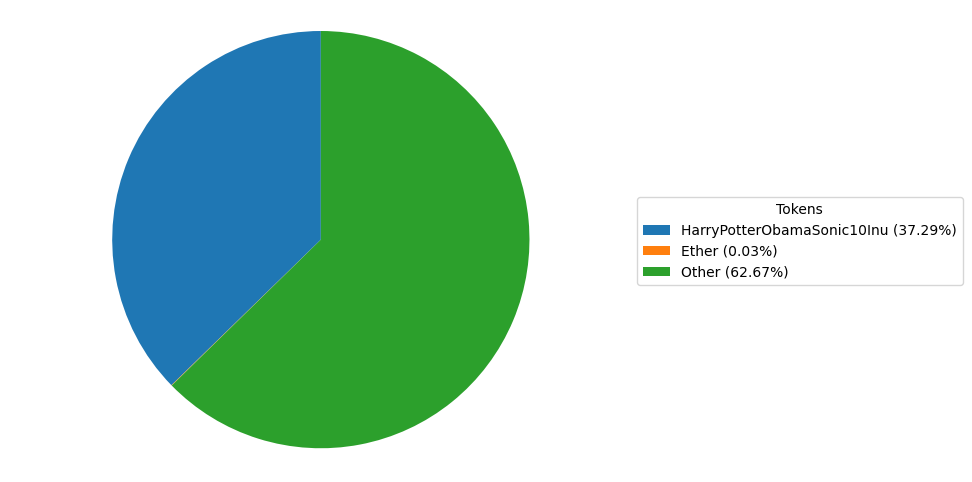

Total portfolio value is $4397205 USD


In [ ]:
_portfolio = hpbitcoin_holder_data.portfolios[1]
print(f"Portfolio for wallet: {_portfolio['address']}")
portfolio_to_pie_chart(token_list, _portfolio)
print(f"Total portfolio value is ${_portfolio['portfolio_sum']:.0f} USD")

Alright, now let's think about what other functionality we want - given an intersection dict. This could have come from several different means, but ultimately comes from a list of portfolios. 

So, we have:
    - A list of portfolios.
    - An intersection dictionary.



In [ ]:
#| export
def print_portfolios_more_than_k(obj:object, k:int=2):
    portfolios = obj.portfolios
    intersect_dict = obj.intersect_dict
    n = len(portfolios)
    date = obj.date
    
    token_list = contract_name_if_more_than_k_holders(intersect_dict=intersect_dict, k=k)
    
    formatted_token_list = '\n\t'.join([f"{name}: {address}" for name, address in token_list])
    
    if hasattr(obj, 'top_n_holders'):
        tokenName = obj.tokenName
        test_eq(obj.n, n)  # I am assuming you have a method to compare obj.n and n.
        print(f"The tokens where, for each token, more than {k} out of the top {n} holders of {tokenName} hold them as of {date} are:\n\t{formatted_token_list}\n")
    else:
        print(f"The tokens where, for each token, more than {k} out of the {n} portfolios hold them as of {date} are:\n\t{formatted_token_list}\n")
    
    for token in token_list:
        print(f"Printing the portfolios that hold {token}:\n")
        _portfolios = [portfolio for portfolio in portfolios if token[1] in [holding['contract_address'] for holding in portfolio['portfolio']]]
        
        # # If you want to print tokens in portfolios
        # print_tokens_in_portfolios([token], _portfolios)
        
        # If you want to plot pie chart for each portfolio
        for portfolio in _portfolios:
            print(f"Portfolio: {portfolio['address']} has total value ${portfolio['portfolio_sum']:.0f} USD \n")
            portfolio_to_pie_chart(token_list, portfolio)
            #print_tokens_in_portfolios(token_list,portfolios=[portfolio])
            

# k=4
# print_portfolios_more_than_k(hpbitcoin_holder_data,k=k)

How to use `print_portfolios_more_than_k` - please see next few cells.

The tokens where, for each token, more than 1 out of the top 10 holders of HarryPotterObamaSonic10Inu hold them as of 2023-09-24 are:
	Ether: 0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
	HarryPotterObamaSonic10Inu: 0x72e4f9f808c49a2a61de9c5896298920dc4eeea9
	MAGA: 0x576e2bed8f7b46d34016198911cdf9886f78bea7
	Wrapped Ether: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
	USD Coin: 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48

Printing the portfolios that hold ('Ether', '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'):

Portfolio: 0x51205a732f40e57d58c7823430e8168c4a0e685b has total value $2011335 USD 



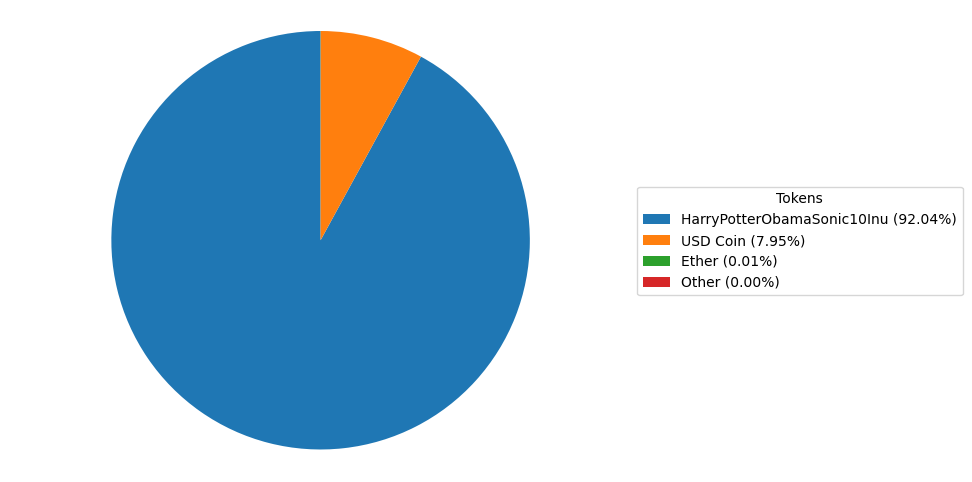

Portfolio: 0xa54d176707d72e22163630ffb82342559e00b547 has total value $4397205 USD 



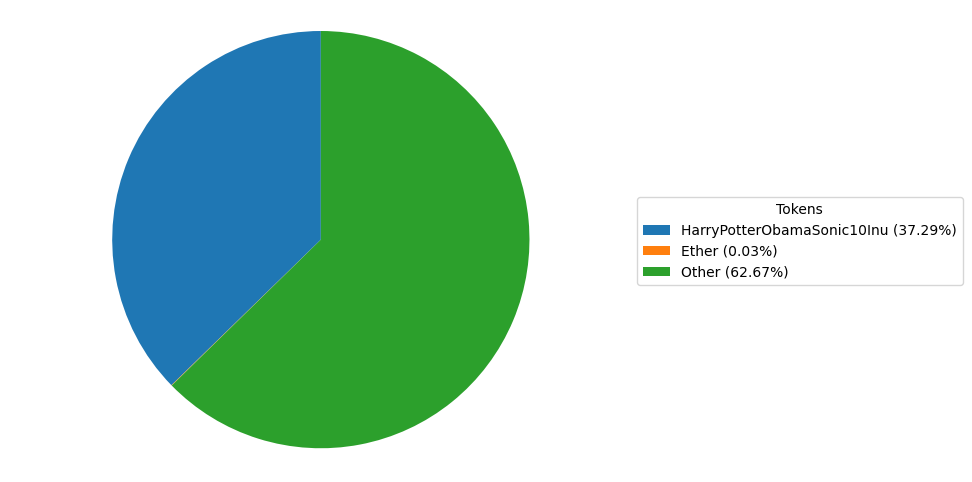

Portfolio: 0x9badae7a4a9030d094b799f13b306d2f462f9be9 has total value $1747611 USD 



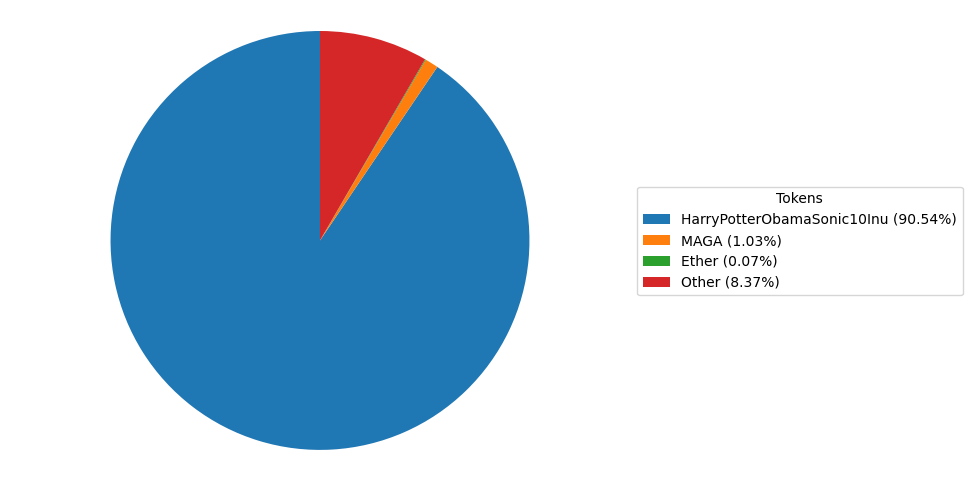

Portfolio: 0x2347d6cf4f57a19ff289f2a0a1a246c56f8d5e8a has total value $1424659 USD 



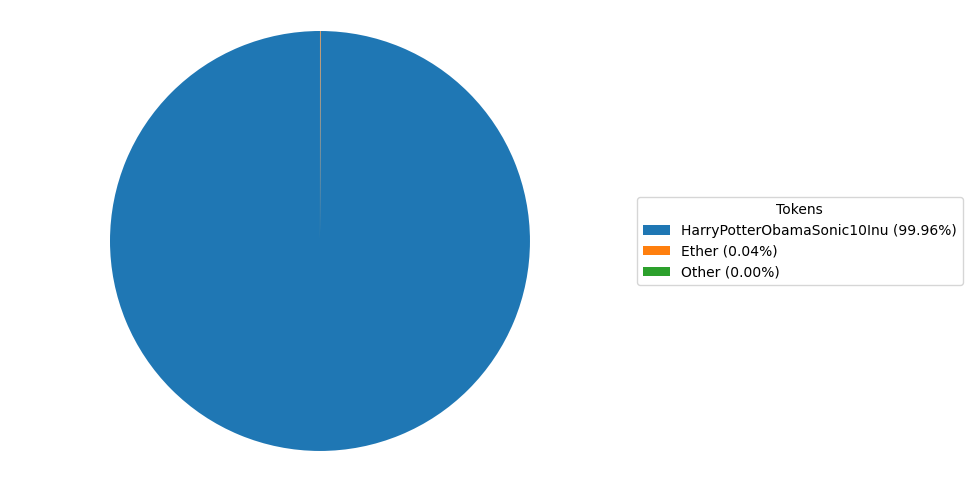

Portfolio: 0x1b1e1d7c62dc1c5655562286f8f4be57c6a309fb has total value $1734419 USD 



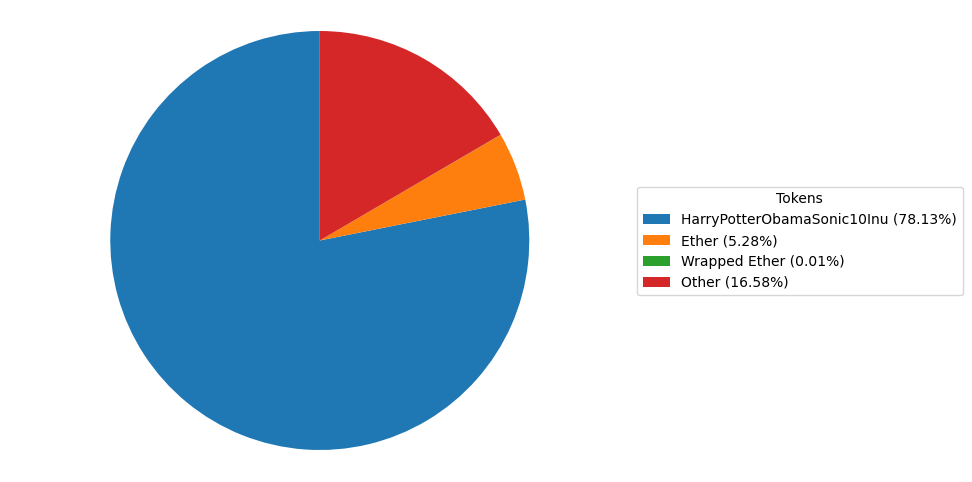

Portfolio: 0x22ae2a3ddd39781e2b2de836f46773eabe78b7ae has total value $2017597 USD 



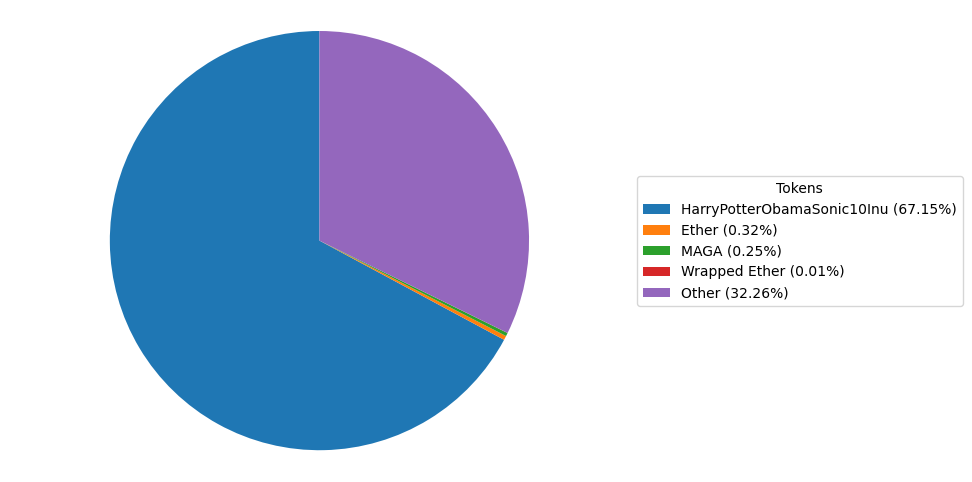

Portfolio: 0xa4644953ad98ed5a7ff106ed9a3909c9aebcbc31 has total value $4441413 USD 



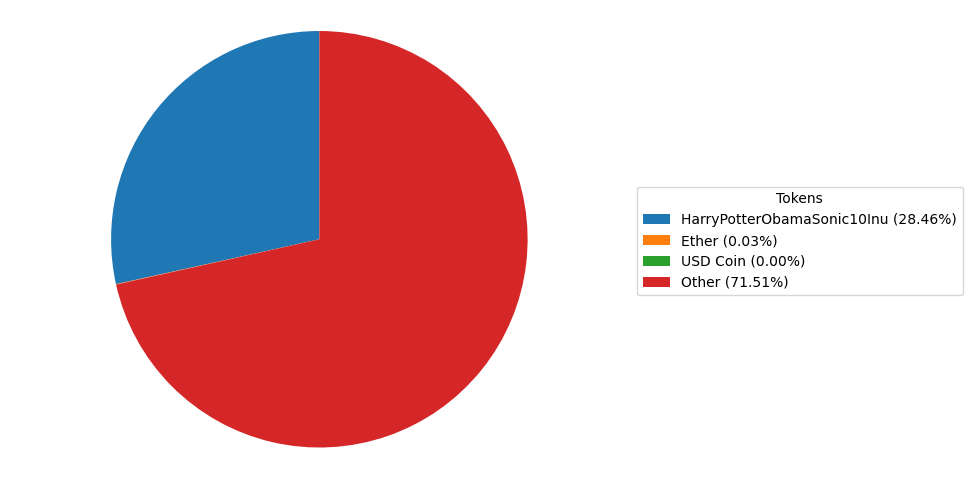

Portfolio: 0x9a8c3f41a532d554de8a934864d91053871e371d has total value $1151505 USD 



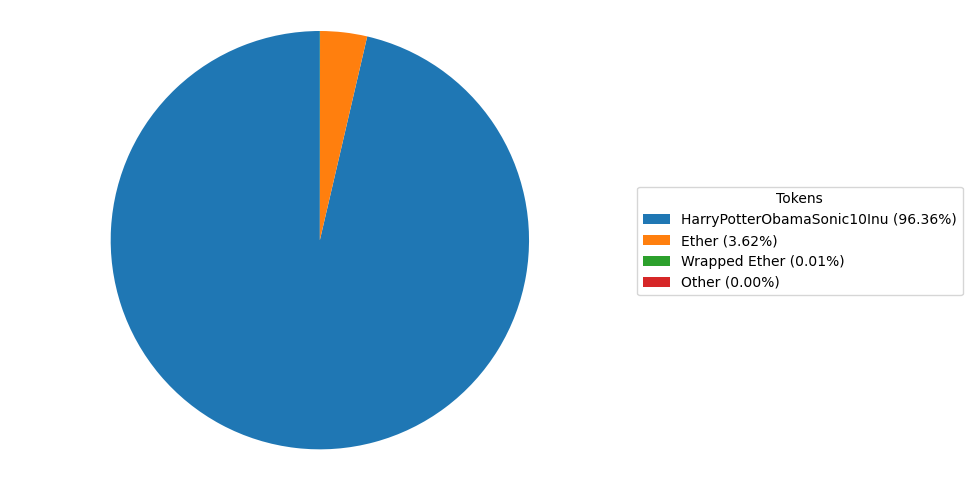

Portfolio: 0xd4d32a2d840baddc9a08311af4ac77f96728b446 has total value $1102763 USD 



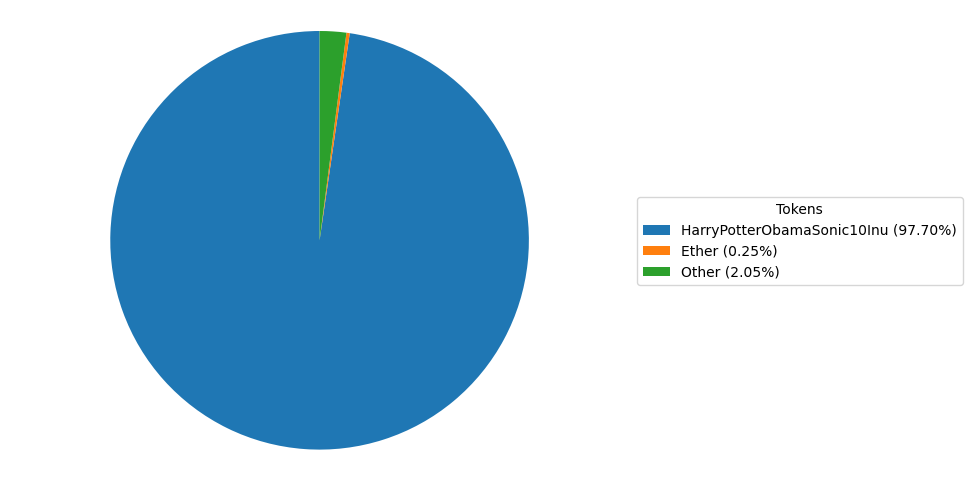

Printing the portfolios that hold ('HarryPotterObamaSonic10Inu', '0x72e4f9f808c49a2a61de9c5896298920dc4eeea9'):

Portfolio: 0x51205a732f40e57d58c7823430e8168c4a0e685b has total value $2011335 USD 



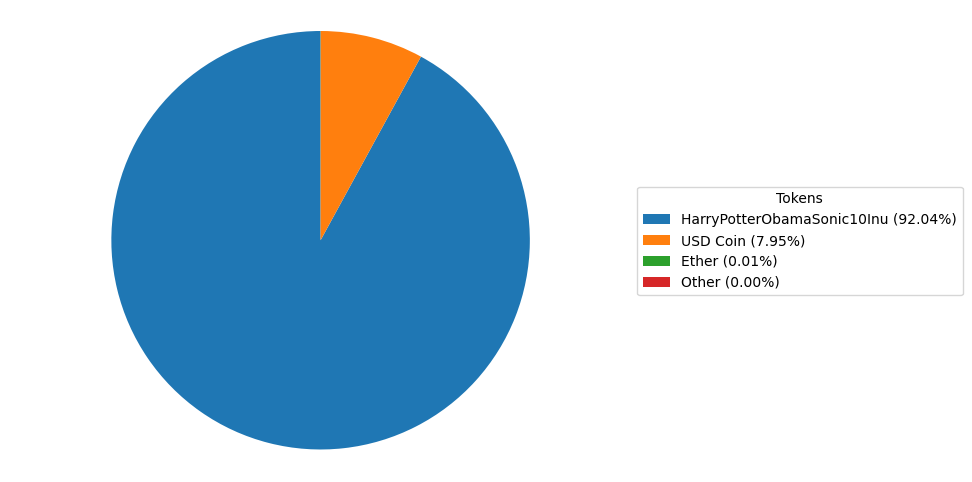

Portfolio: 0xa54d176707d72e22163630ffb82342559e00b547 has total value $4397205 USD 



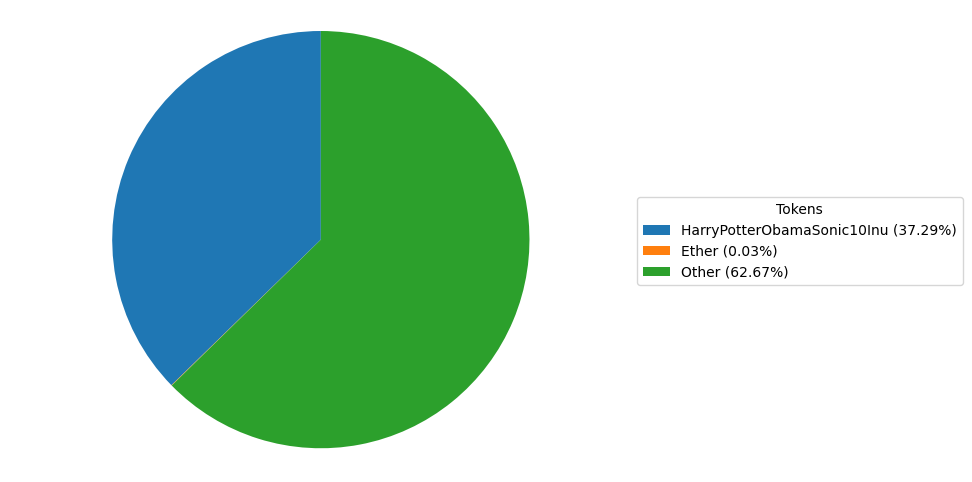

Portfolio: 0x9badae7a4a9030d094b799f13b306d2f462f9be9 has total value $1747611 USD 



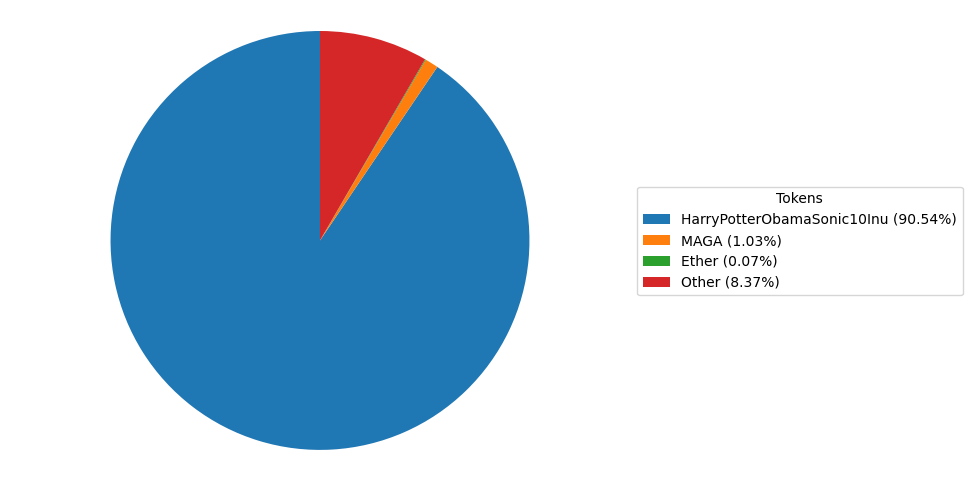

Portfolio: 0x2347d6cf4f57a19ff289f2a0a1a246c56f8d5e8a has total value $1424659 USD 



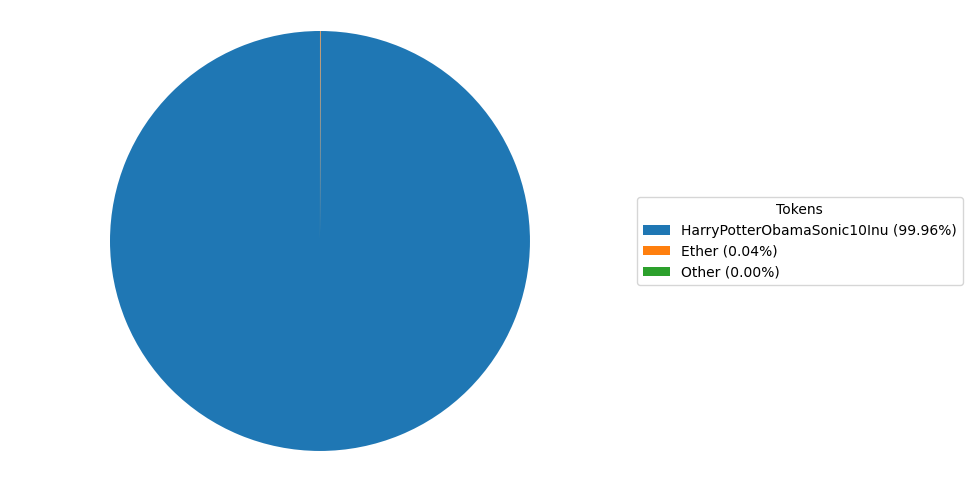

Portfolio: 0x1b1e1d7c62dc1c5655562286f8f4be57c6a309fb has total value $1734419 USD 



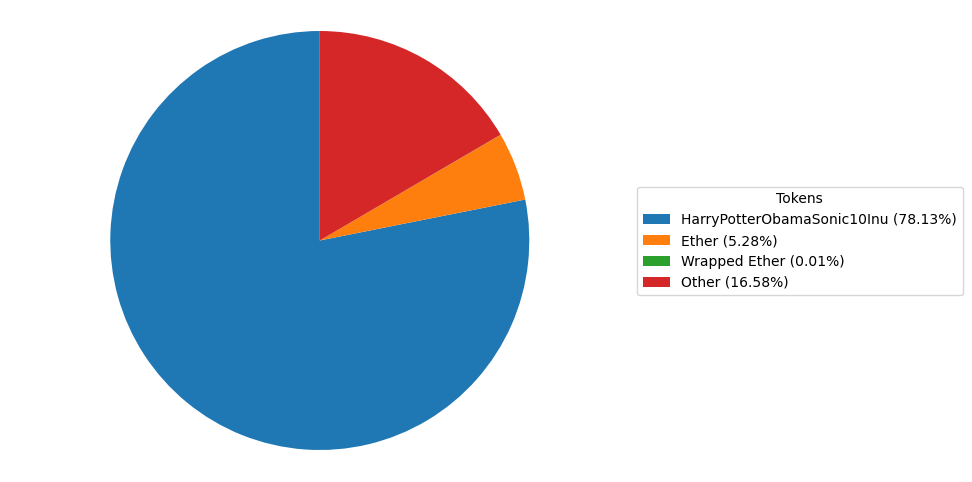

Portfolio: 0x22ae2a3ddd39781e2b2de836f46773eabe78b7ae has total value $2017597 USD 



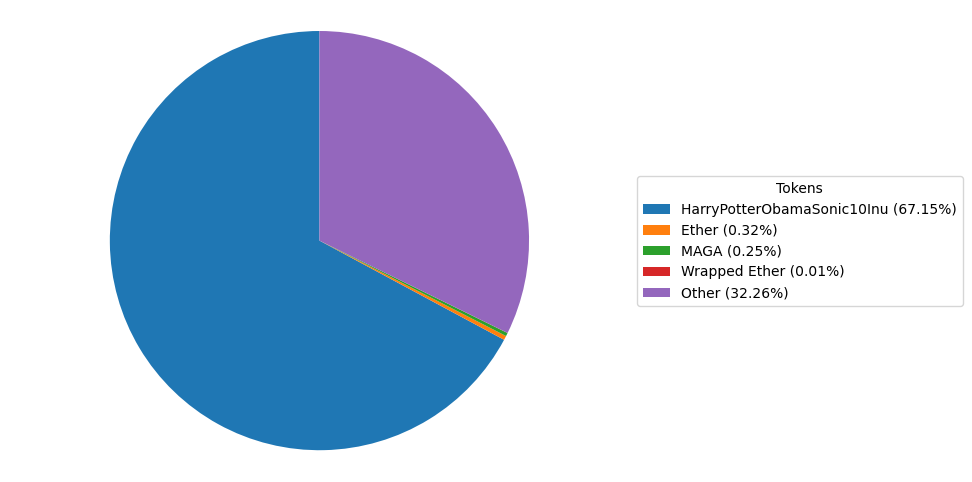

Portfolio: 0x2cc846fff0b08fb3bffad71f53a60b4b6e6d6482 has total value $2644861 USD 



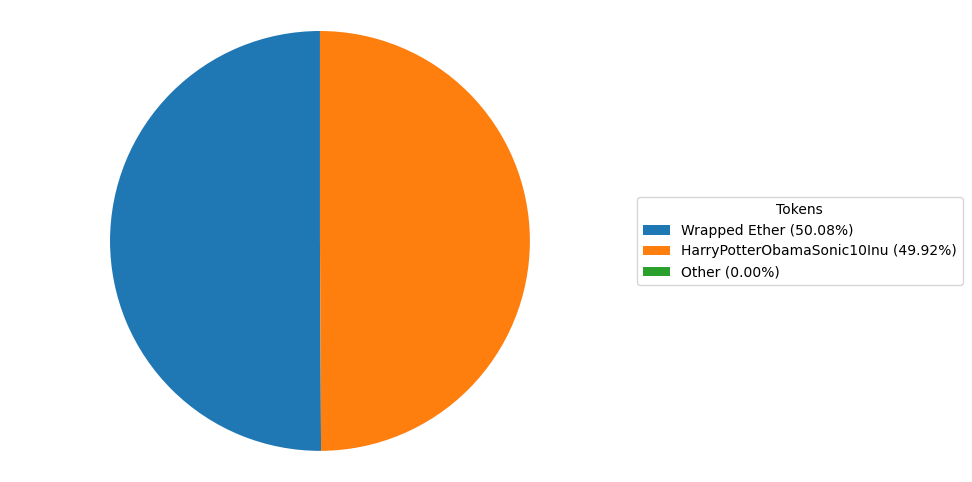

Portfolio: 0xa4644953ad98ed5a7ff106ed9a3909c9aebcbc31 has total value $4441413 USD 



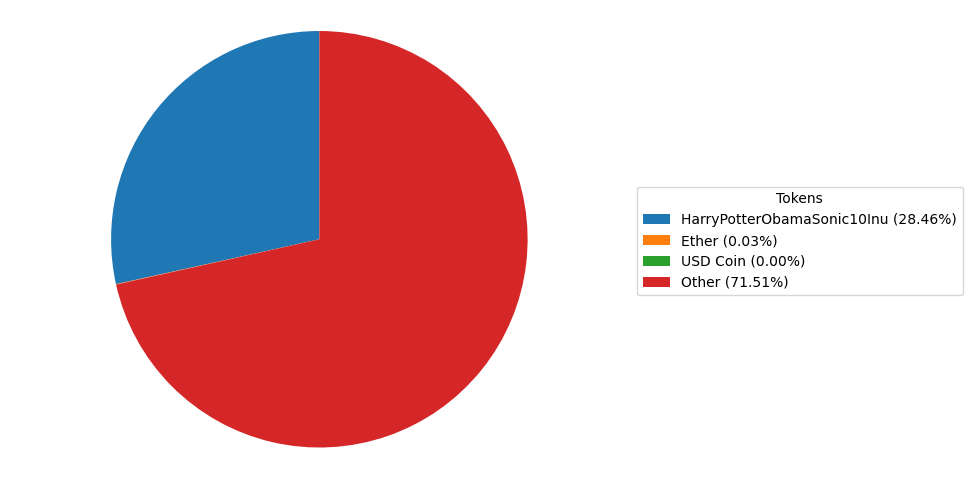

Portfolio: 0x9a8c3f41a532d554de8a934864d91053871e371d has total value $1151505 USD 



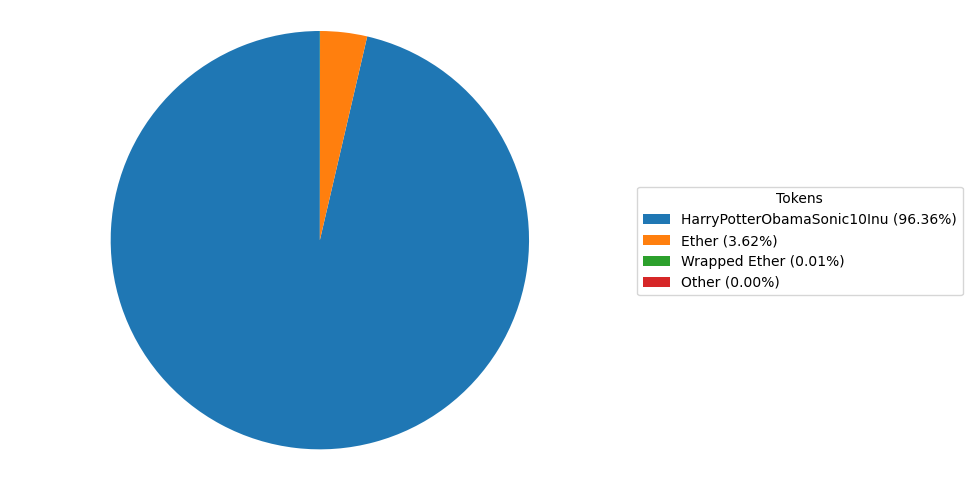

Portfolio: 0xd4d32a2d840baddc9a08311af4ac77f96728b446 has total value $1102763 USD 



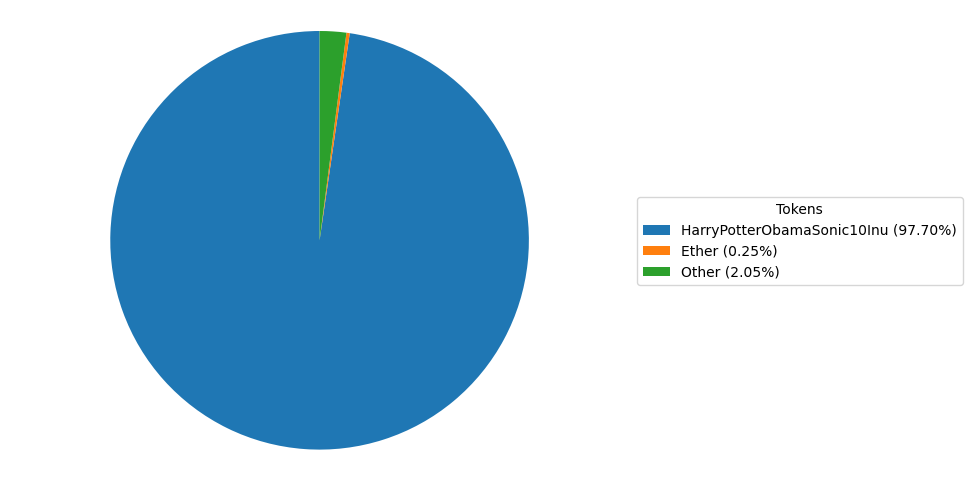

Printing the portfolios that hold ('MAGA', '0x576e2bed8f7b46d34016198911cdf9886f78bea7'):

Portfolio: 0x9badae7a4a9030d094b799f13b306d2f462f9be9 has total value $1747611 USD 



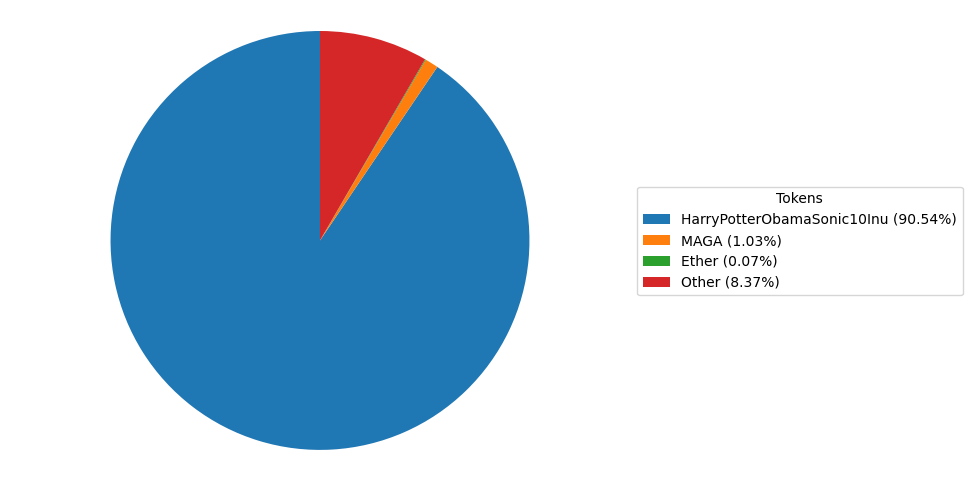

Portfolio: 0x22ae2a3ddd39781e2b2de836f46773eabe78b7ae has total value $2017597 USD 



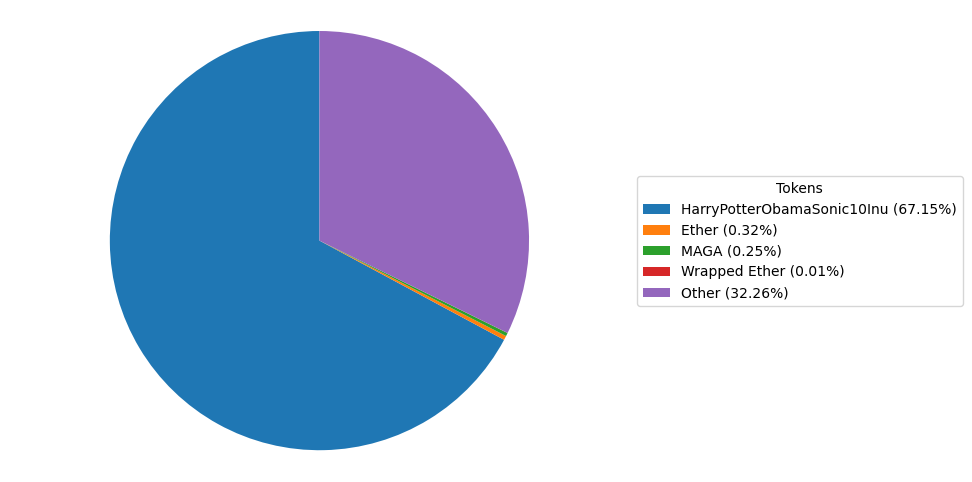

Printing the portfolios that hold ('Wrapped Ether', '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'):

Portfolio: 0x1b1e1d7c62dc1c5655562286f8f4be57c6a309fb has total value $1734419 USD 



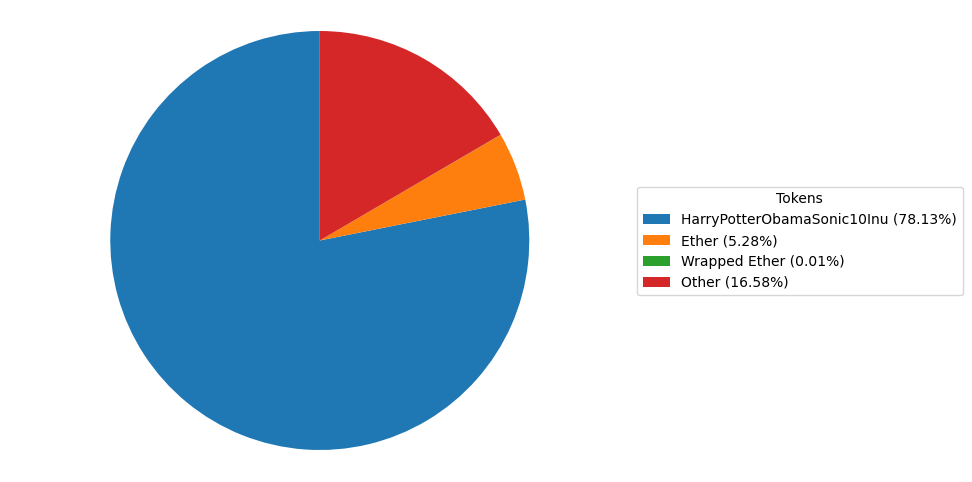

Portfolio: 0x22ae2a3ddd39781e2b2de836f46773eabe78b7ae has total value $2017597 USD 



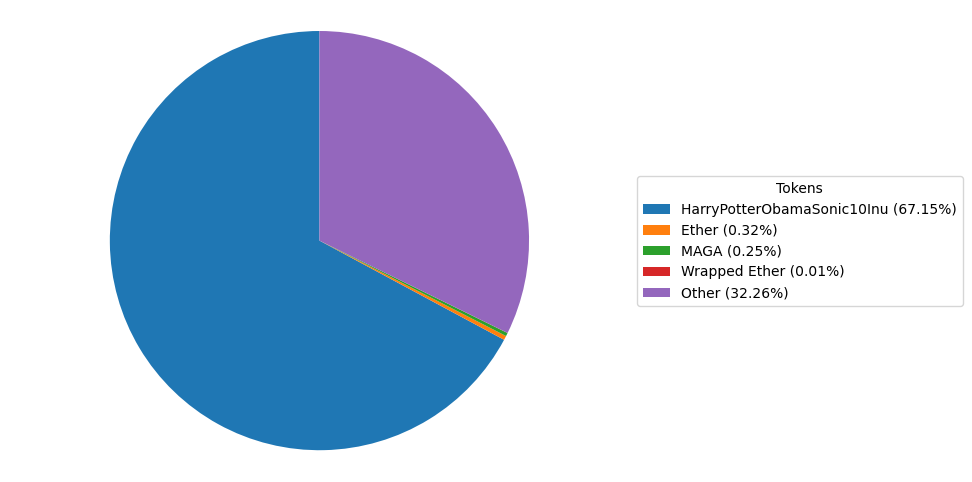

Portfolio: 0x2cc846fff0b08fb3bffad71f53a60b4b6e6d6482 has total value $2644861 USD 



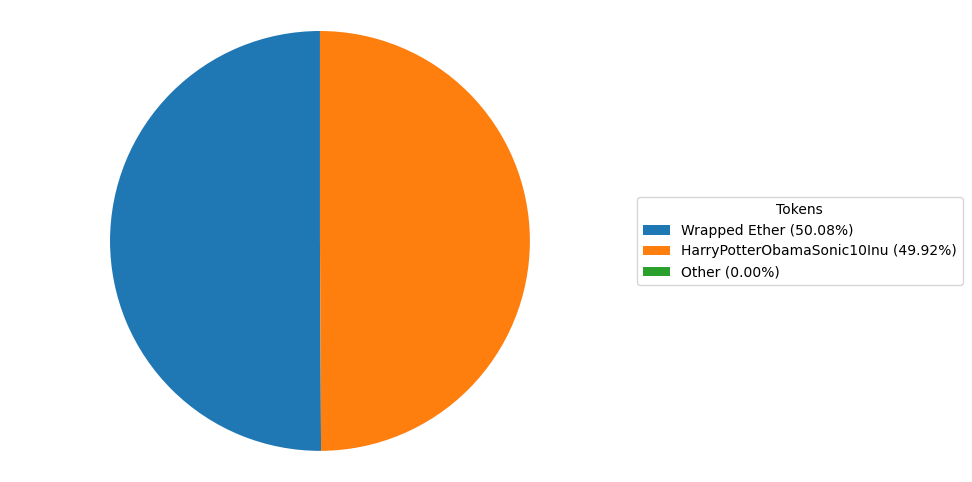

Portfolio: 0x9a8c3f41a532d554de8a934864d91053871e371d has total value $1151505 USD 



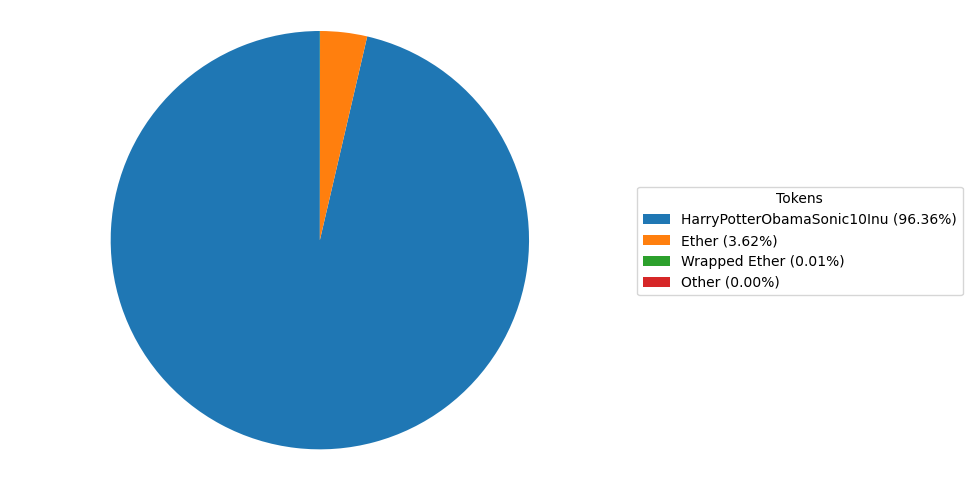

Printing the portfolios that hold ('USD Coin', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'):

Portfolio: 0x51205a732f40e57d58c7823430e8168c4a0e685b has total value $2011335 USD 



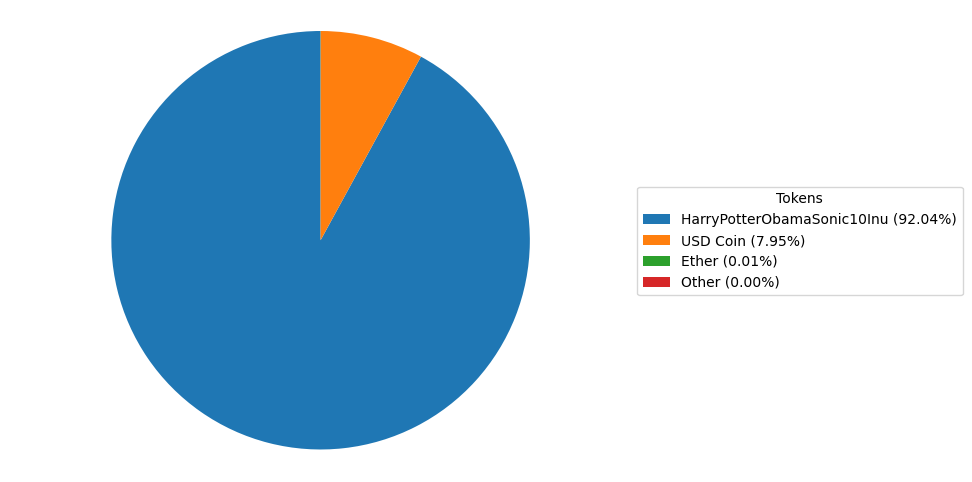

Portfolio: 0xa4644953ad98ed5a7ff106ed9a3909c9aebcbc31 has total value $4441413 USD 



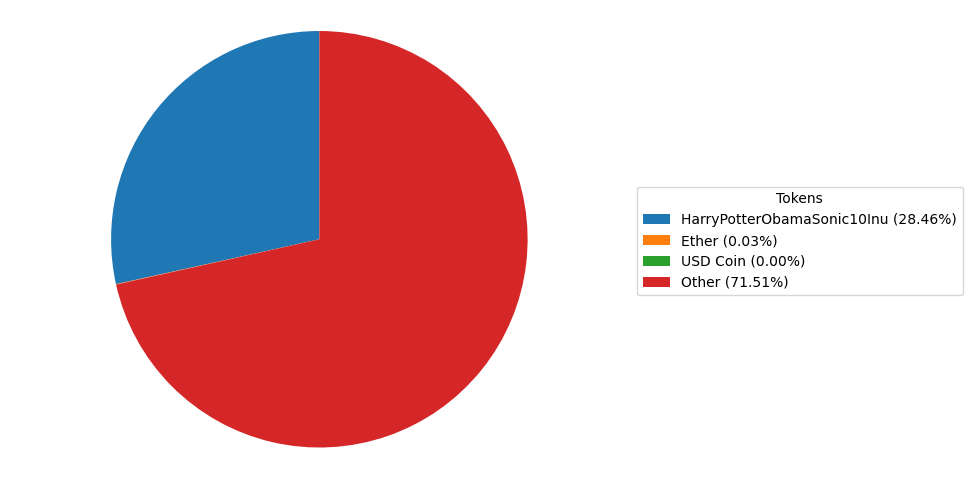

In this case, the `portfolios` are the same as the `top_n_holders`, but this doesn't have to be the case. See the source code!
 Also see the following cells.


In [ ]:

k=1
print_portfolios_more_than_k(hpbitcoin_holder_data,k=k)
print('''In this case, the `portfolios` are the same as the `top_n_holders`, but this doesn't have to be the case. See the source code!\n Also see the following cells.''')

#Another example in next cell with k=2

The tokens where, for each token, more than 2 out of the top 10 holders of HarryPotterObamaSonic10Inu hold them as of 2023-09-24 are:
	Ether: 0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
	HarryPotterObamaSonic10Inu: 0x72e4f9f808c49a2a61de9c5896298920dc4eeea9
	Wrapped Ether: 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2

Printing the portfolios that hold ('Ether', '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'):

Portfolio: 0x51205a732f40e57d58c7823430e8168c4a0e685b has total value $2011335 USD 



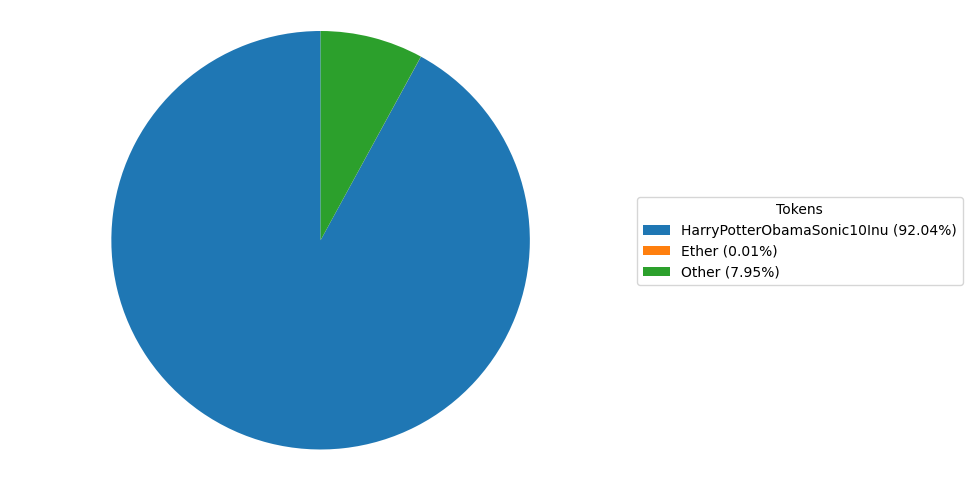

Portfolio: 0xa54d176707d72e22163630ffb82342559e00b547 has total value $4397205 USD 



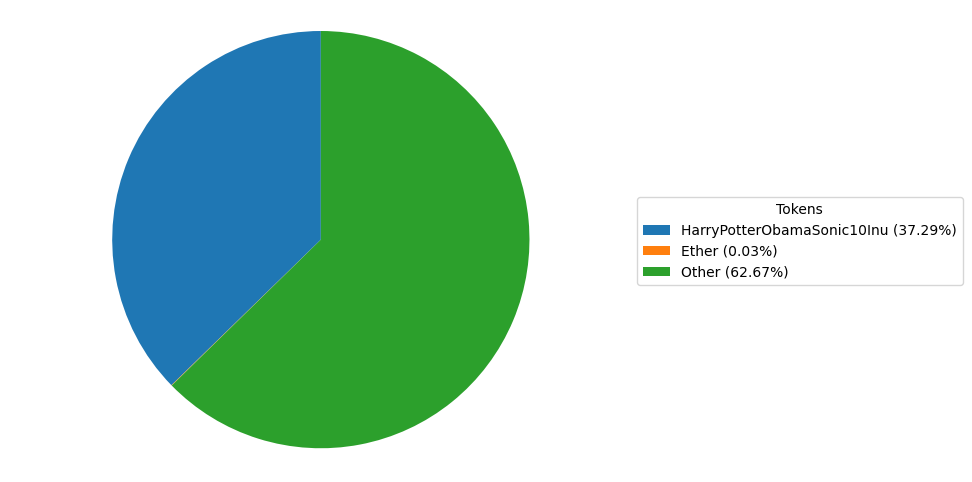

Portfolio: 0x9badae7a4a9030d094b799f13b306d2f462f9be9 has total value $1747611 USD 



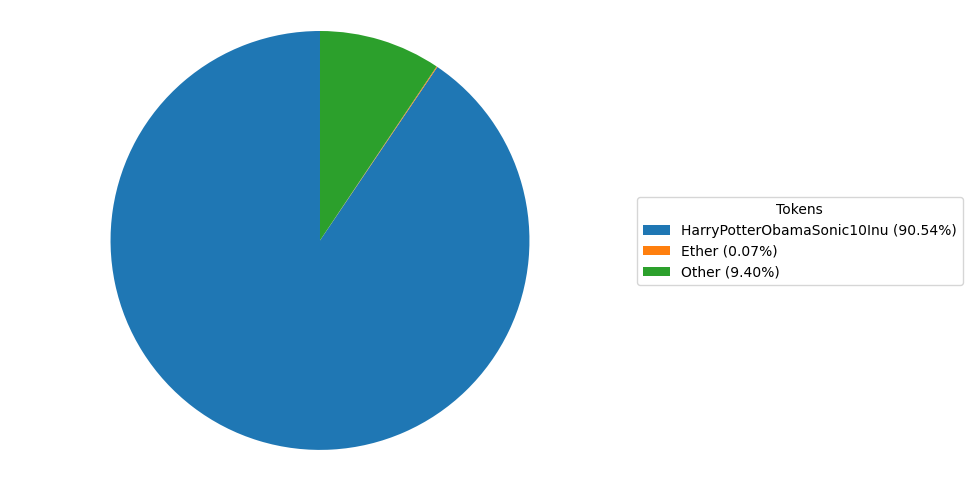

Portfolio: 0x2347d6cf4f57a19ff289f2a0a1a246c56f8d5e8a has total value $1424659 USD 



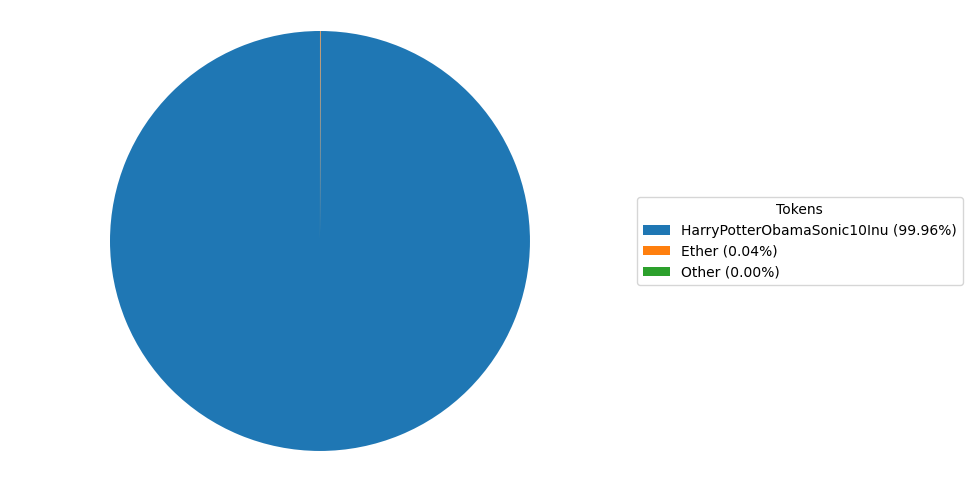

Portfolio: 0x1b1e1d7c62dc1c5655562286f8f4be57c6a309fb has total value $1734419 USD 



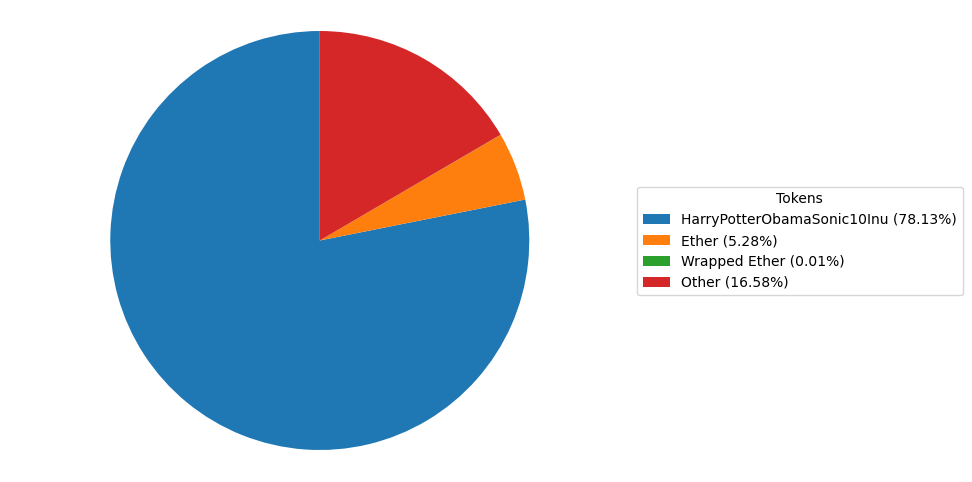

Portfolio: 0x22ae2a3ddd39781e2b2de836f46773eabe78b7ae has total value $2017597 USD 



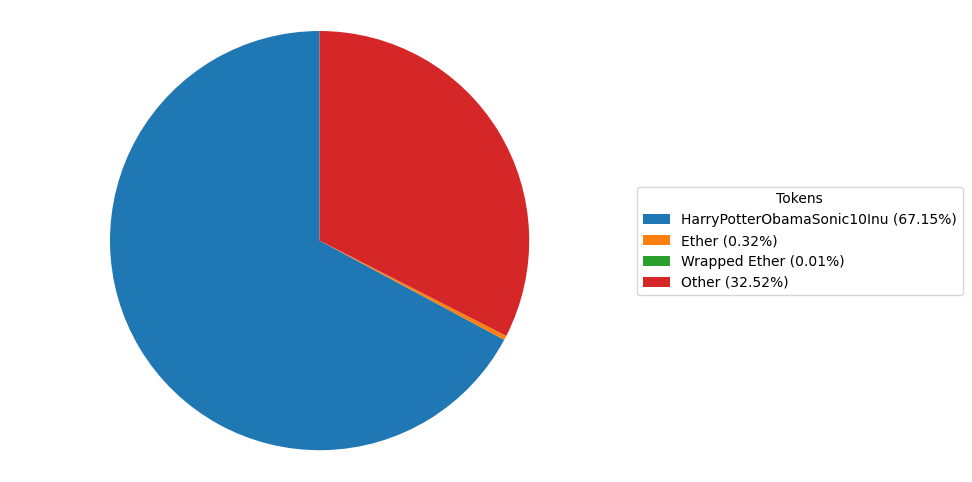

Portfolio: 0xa4644953ad98ed5a7ff106ed9a3909c9aebcbc31 has total value $4441413 USD 



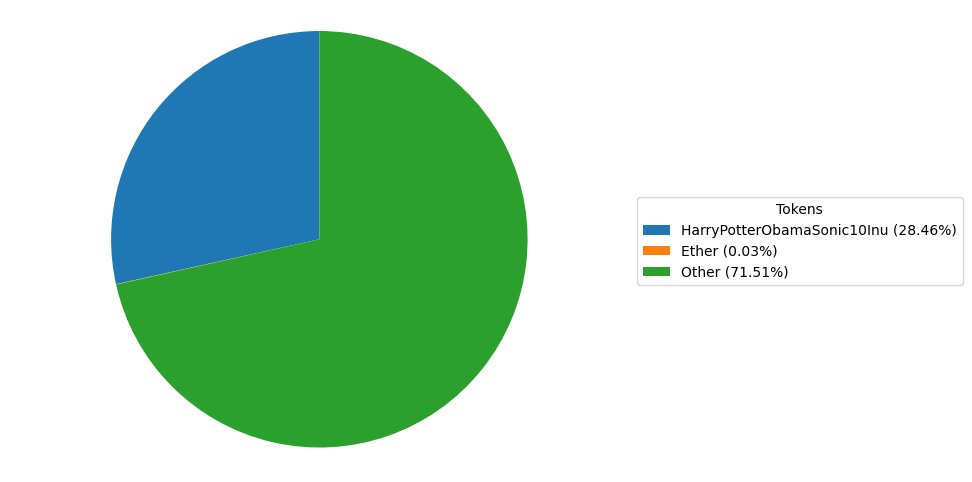

Portfolio: 0x9a8c3f41a532d554de8a934864d91053871e371d has total value $1151505 USD 



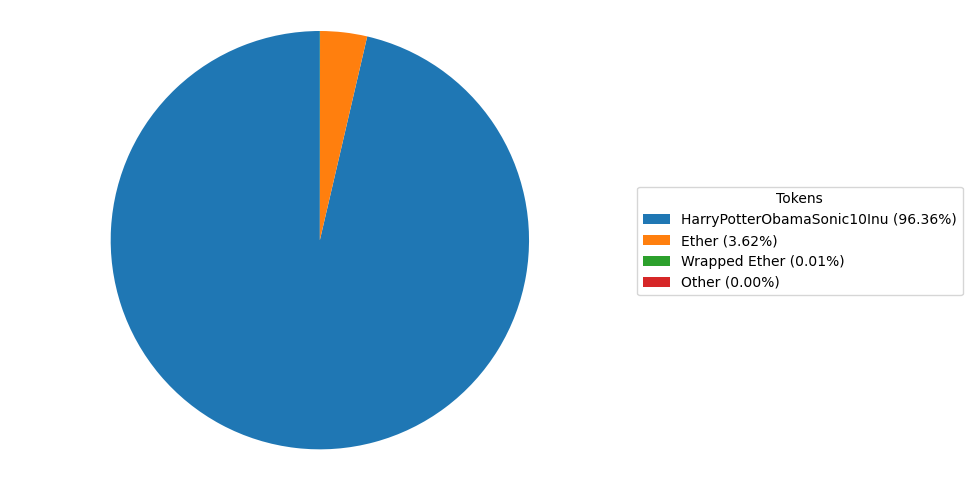

Portfolio: 0xd4d32a2d840baddc9a08311af4ac77f96728b446 has total value $1102763 USD 



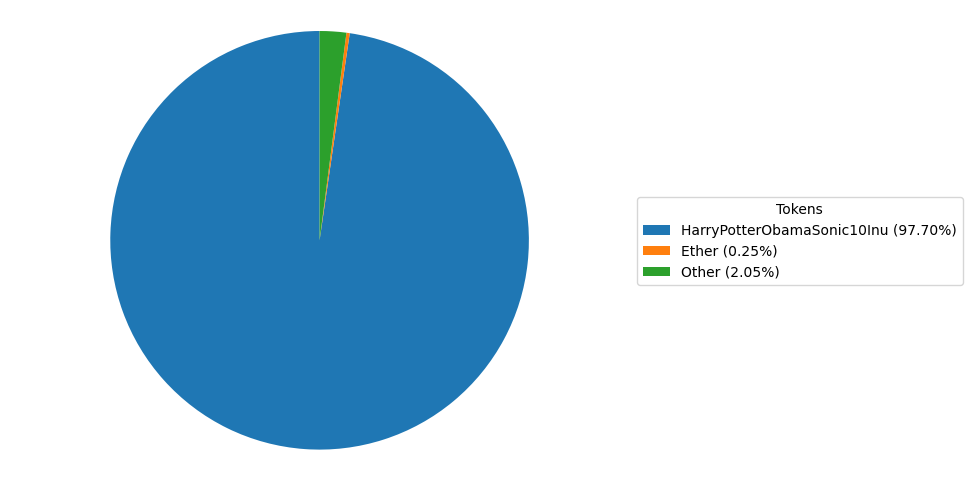

Printing the portfolios that hold ('HarryPotterObamaSonic10Inu', '0x72e4f9f808c49a2a61de9c5896298920dc4eeea9'):

Portfolio: 0x51205a732f40e57d58c7823430e8168c4a0e685b has total value $2011335 USD 



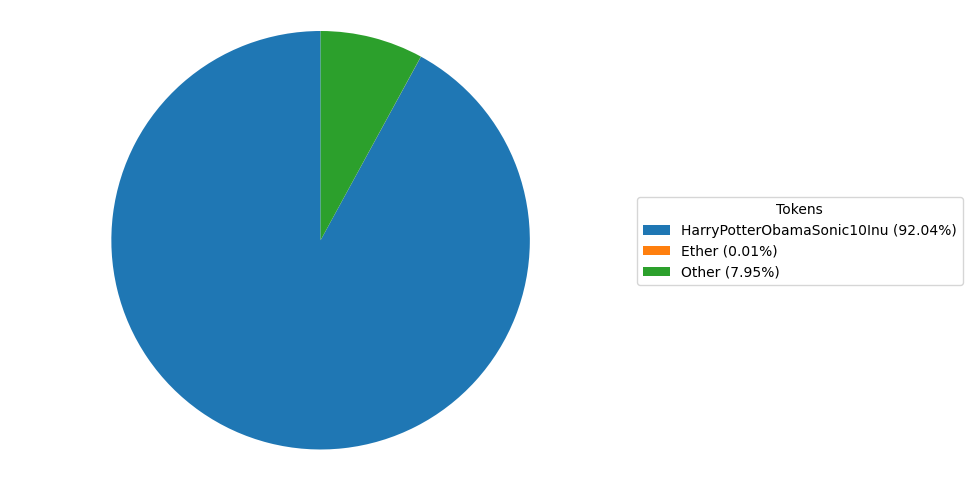

Portfolio: 0xa54d176707d72e22163630ffb82342559e00b547 has total value $4397205 USD 



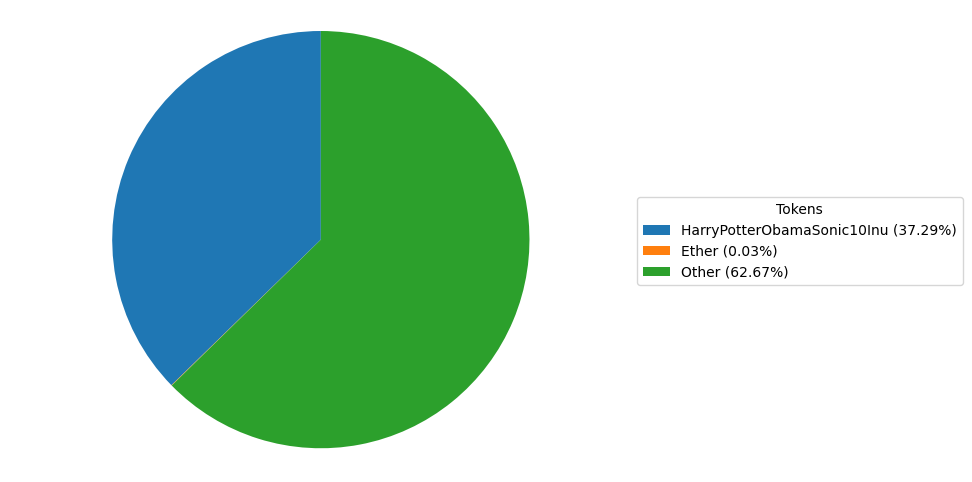

Portfolio: 0x9badae7a4a9030d094b799f13b306d2f462f9be9 has total value $1747611 USD 



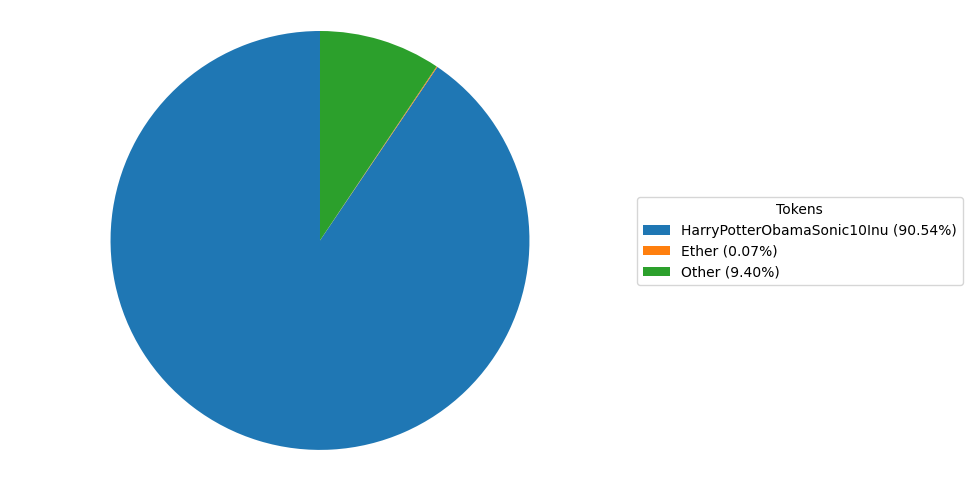

Portfolio: 0x2347d6cf4f57a19ff289f2a0a1a246c56f8d5e8a has total value $1424659 USD 



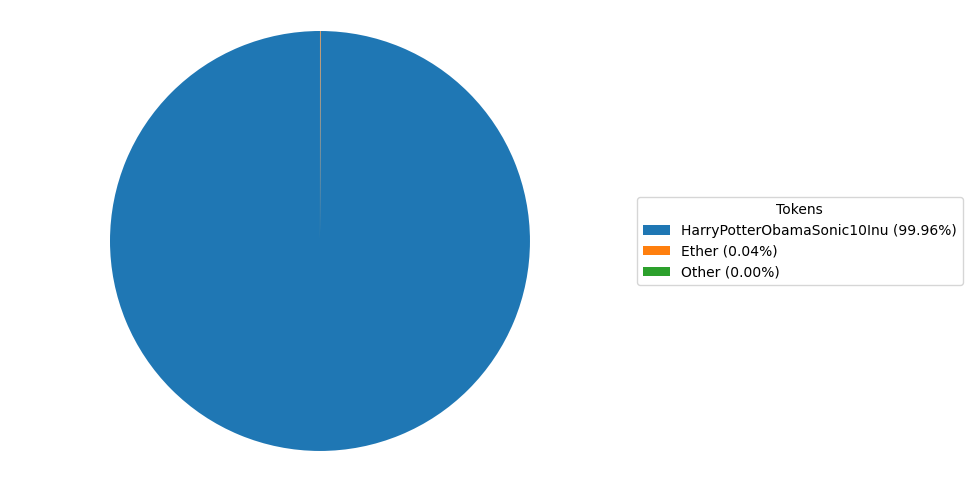

Portfolio: 0x1b1e1d7c62dc1c5655562286f8f4be57c6a309fb has total value $1734419 USD 



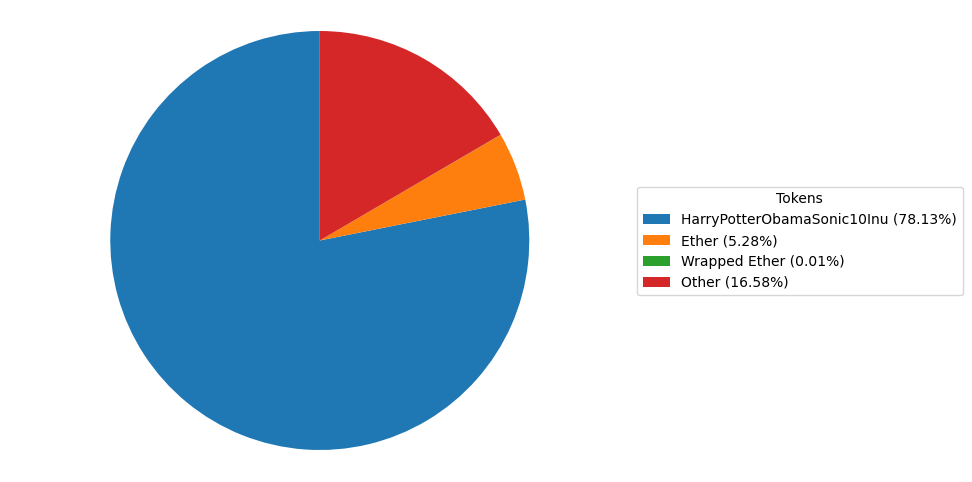

Portfolio: 0x22ae2a3ddd39781e2b2de836f46773eabe78b7ae has total value $2017597 USD 



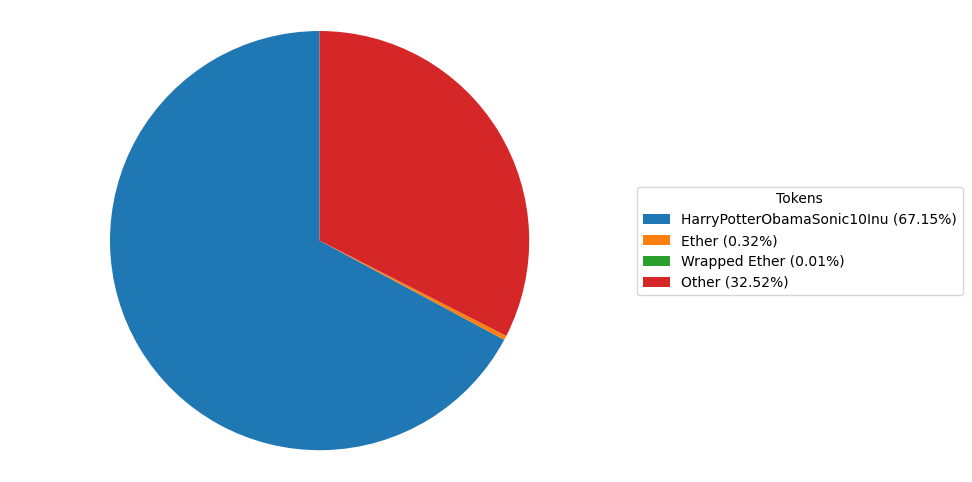

Portfolio: 0x2cc846fff0b08fb3bffad71f53a60b4b6e6d6482 has total value $2644861 USD 



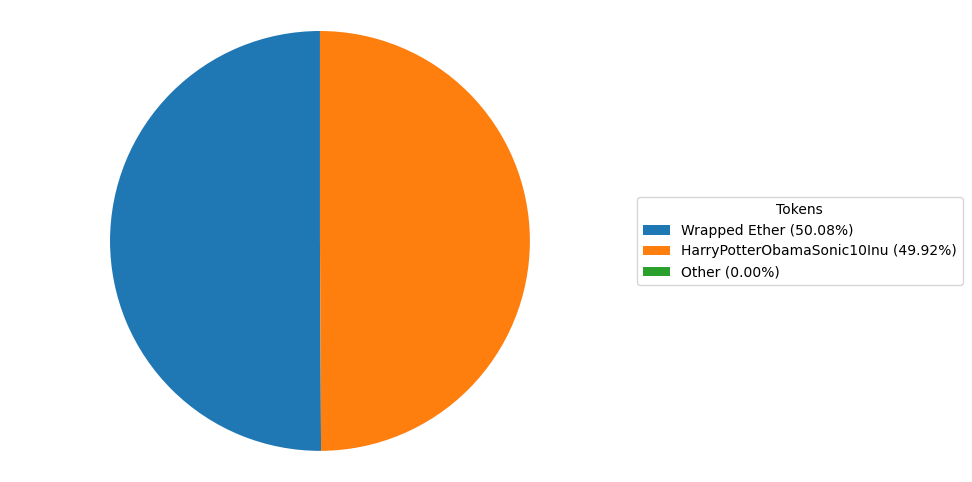

Portfolio: 0xa4644953ad98ed5a7ff106ed9a3909c9aebcbc31 has total value $4441413 USD 



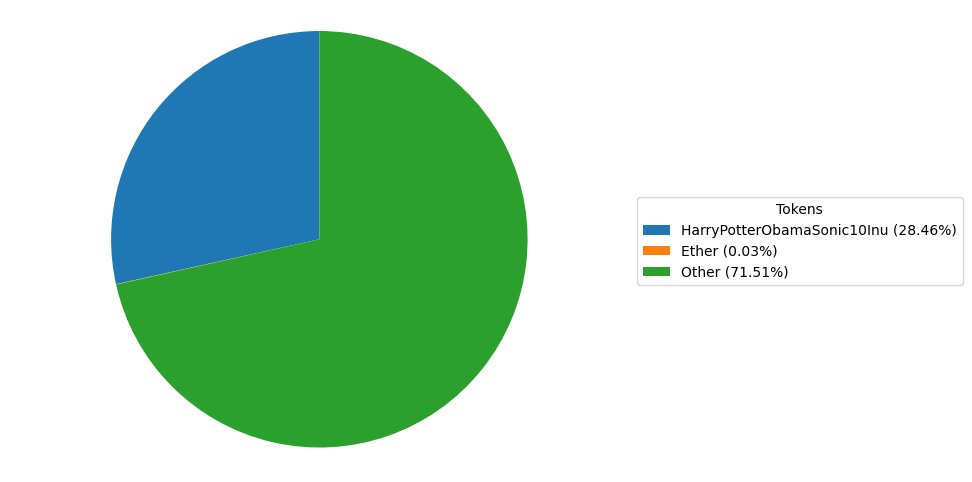

Portfolio: 0x9a8c3f41a532d554de8a934864d91053871e371d has total value $1151505 USD 



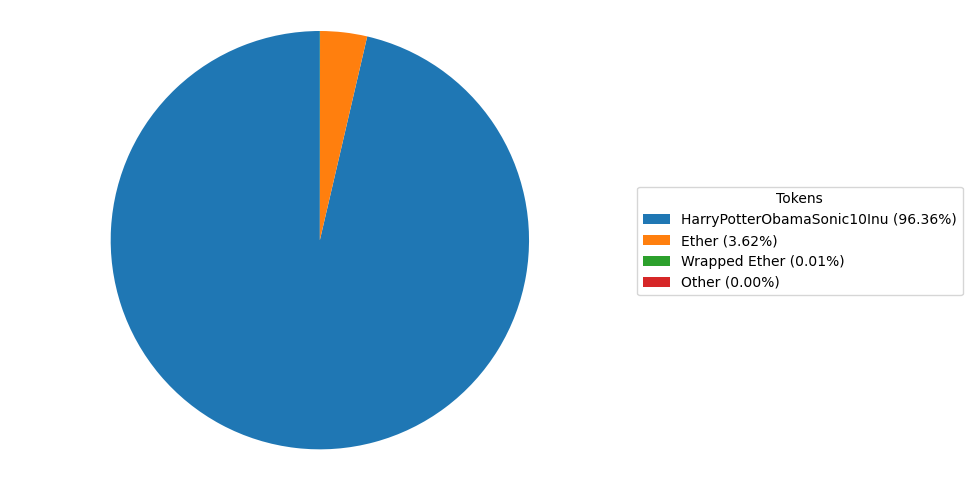

Portfolio: 0xd4d32a2d840baddc9a08311af4ac77f96728b446 has total value $1102763 USD 



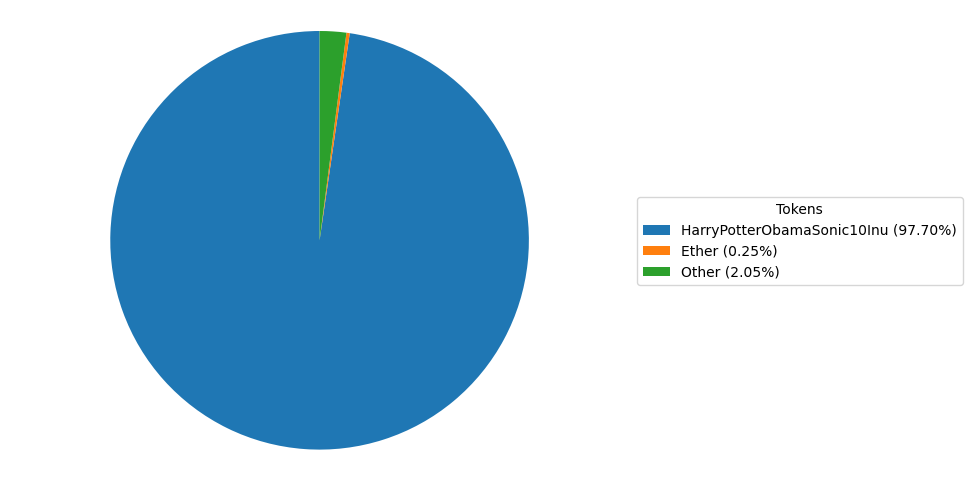

Printing the portfolios that hold ('Wrapped Ether', '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'):

Portfolio: 0x1b1e1d7c62dc1c5655562286f8f4be57c6a309fb has total value $1734419 USD 



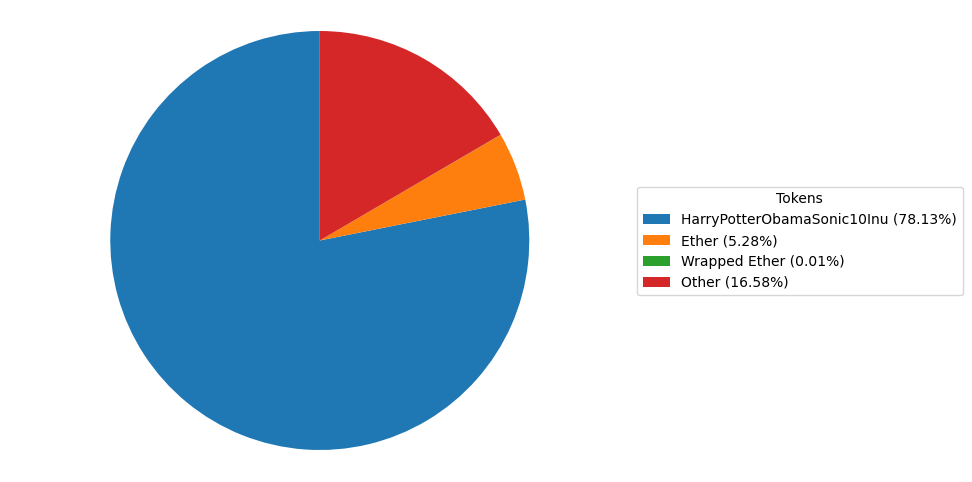

Portfolio: 0x22ae2a3ddd39781e2b2de836f46773eabe78b7ae has total value $2017597 USD 



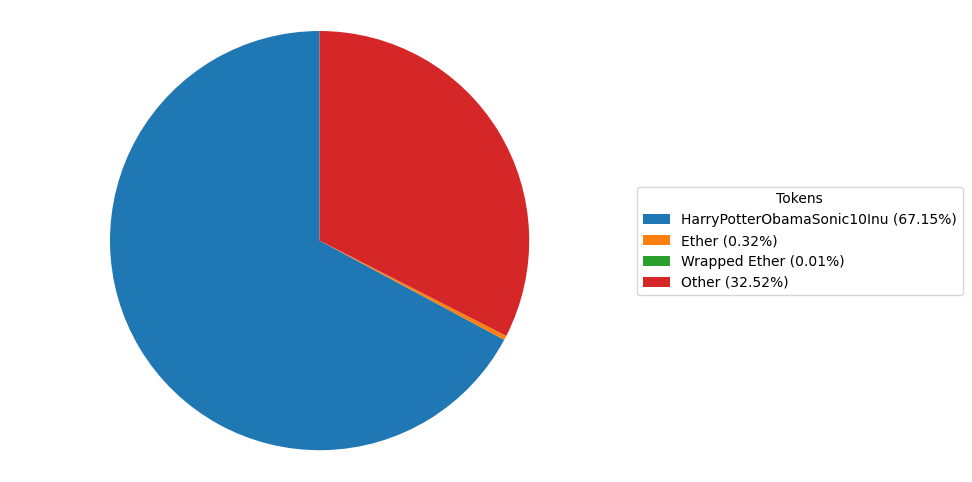

Portfolio: 0x2cc846fff0b08fb3bffad71f53a60b4b6e6d6482 has total value $2644861 USD 



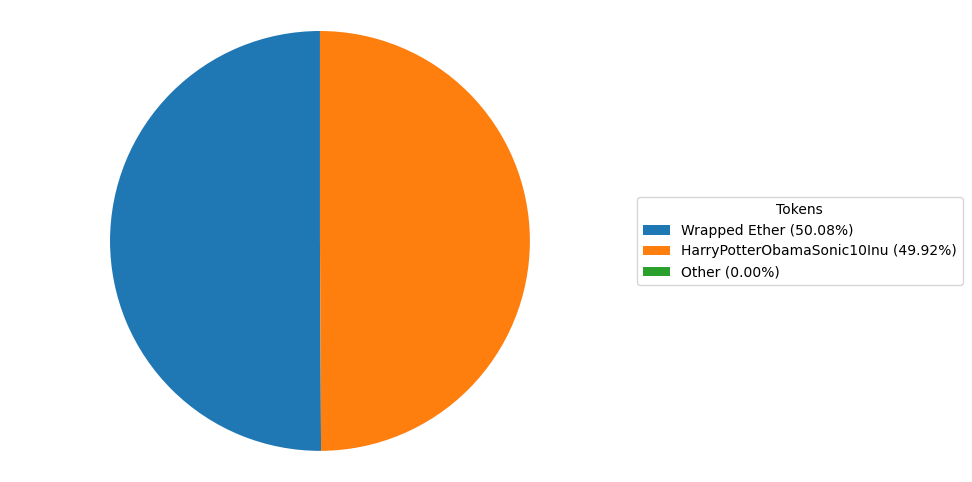

Portfolio: 0x9a8c3f41a532d554de8a934864d91053871e371d has total value $1151505 USD 



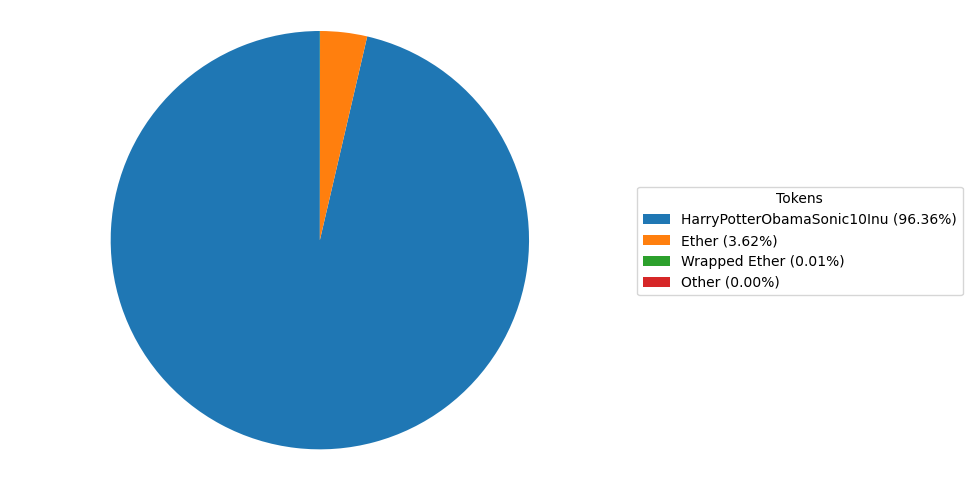

In [ ]:
# #An example with k=2
k=2
print_portfolios_more_than_k(hpbitcoin_holder_data,k=k)


Notice that we just need a `walletlist` to use this functionality:

The tokens where, for each token, more than 1 out of the 2 portfolios hold them as of 2023-06-24 are:
	Ether: 0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
	Pepe: 0x6982508145454ce325ddbe47a25d4ec3d2311933
	USD Coin: 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48

Printing the portfolios that hold ('Ether', '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'):

Portfolio: 0xaf2358e98683265cbd3a48509123d390ddf54534 has total value $8610623 USD 



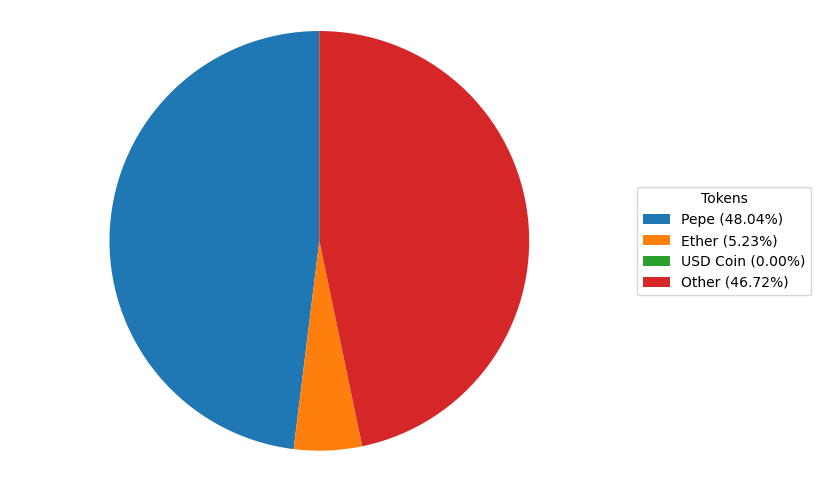

Portfolio: 0x711281c1b26aaed86e40e4caaf76c1962b45e161 has total value $612356 USD 



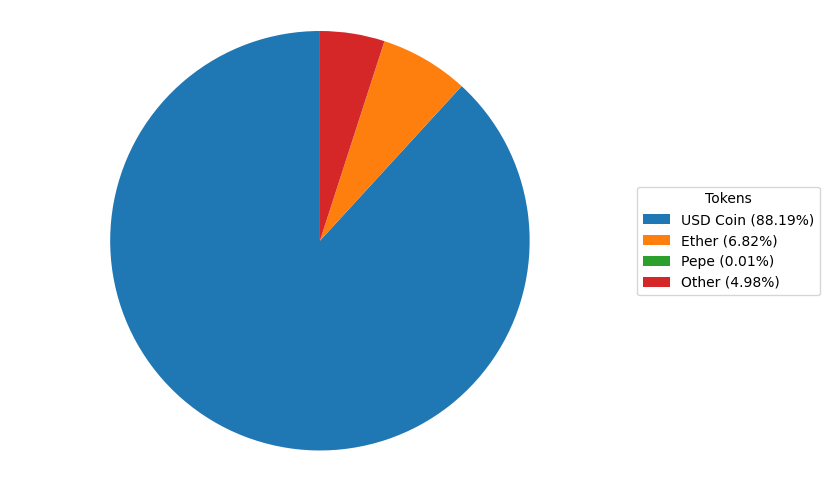

Printing the portfolios that hold ('Pepe', '0x6982508145454ce325ddbe47a25d4ec3d2311933'):

Portfolio: 0xaf2358e98683265cbd3a48509123d390ddf54534 has total value $8610623 USD 



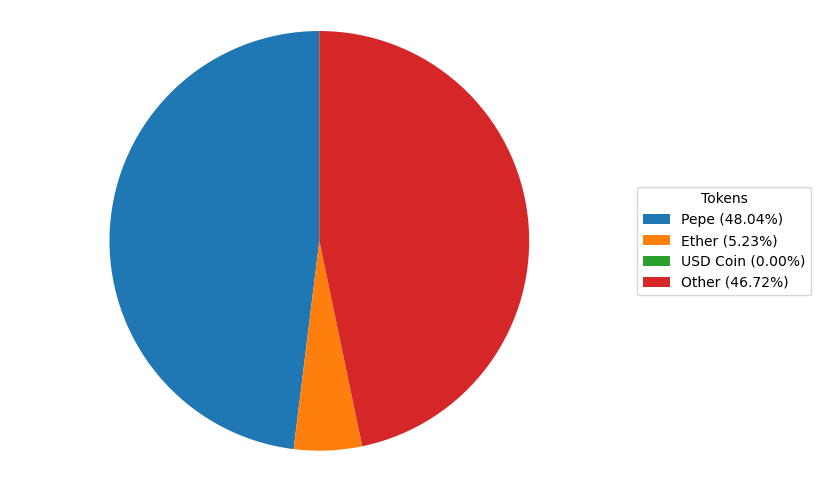

Portfolio: 0x711281c1b26aaed86e40e4caaf76c1962b45e161 has total value $612356 USD 



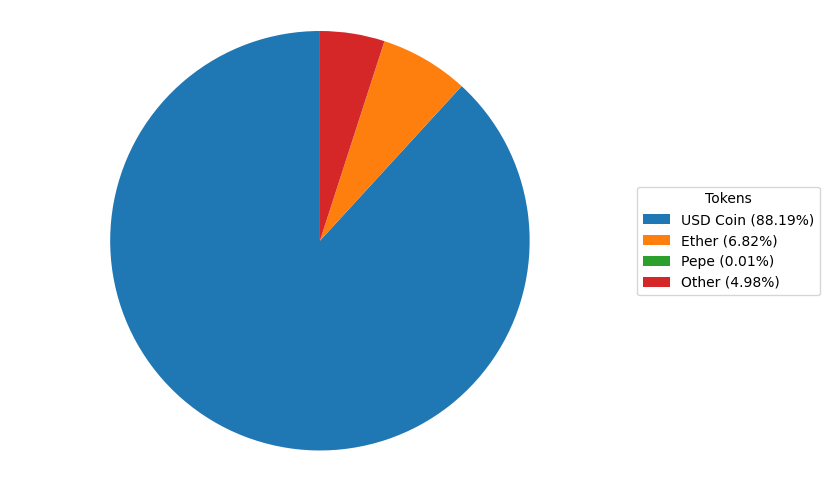

Printing the portfolios that hold ('USD Coin', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'):

Portfolio: 0xaf2358e98683265cbd3a48509123d390ddf54534 has total value $8610623 USD 



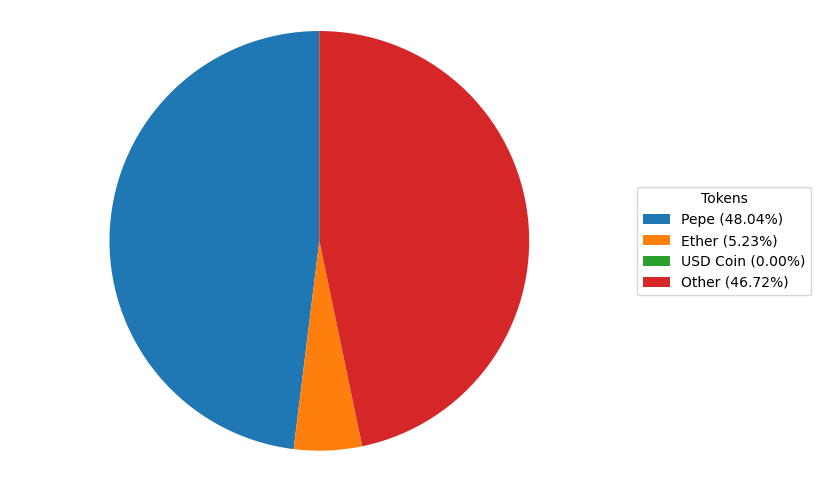

Portfolio: 0x711281c1b26aaed86e40e4caaf76c1962b45e161 has total value $612356 USD 



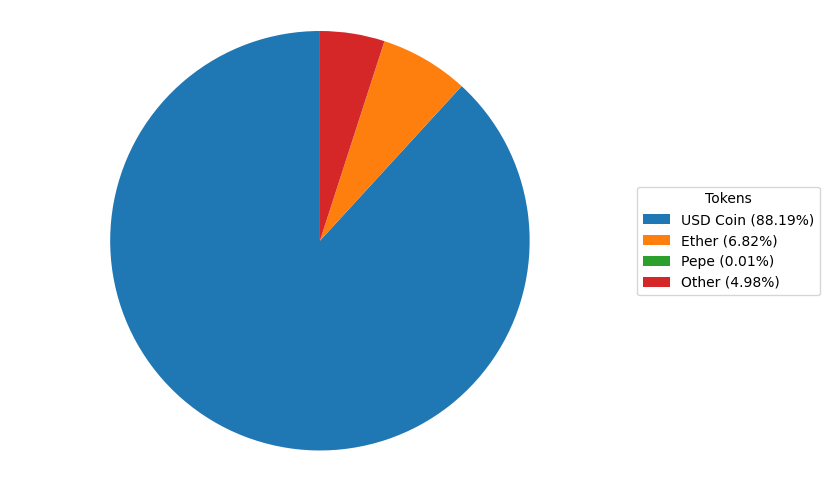

In [ ]:

wallet_1 = '0xaf2358e98683265cbd3a48509123d390ddf54534' #this guy is an early pepe whale
wallet_2 = '0x711281c1b26aaed86e40e4caaf76c1962b45e161' #this guy is an early pepe whale
wallet_list = [{'address':wallet_1},{'address':wallet_2}]
#wallet_1 >> wallet_2, but yeah.
date = '2023-06-24'

#Out:
walletlist_to_intersect_dict = WalletListToIntersectDict(cov_api,wallet_list,chainName,date)

k=1
print_portfolios_more_than_k(walletlist_to_intersect_dict,k=k)


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()